In [1]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter
from modAL.models import ActiveLearner, Committee

import copy

from sklearn.datasets import make_classification
from alipy import ToolBox
from alipy.utils.misc import nsmallestarg, randperm, nlargestarg

/home/vincent/git_repos/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

# Data Processing and Functions

In [3]:
def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df

def process_dataset(curr_df, anomaly_rate, train_perc = 0.85, split=True):

    improved_df = curr_df.copy()

    # Clean the labels
    attempted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    if attempted_labels:
        improved_df.drop(['Attempted Category'], axis=1, inplace=True)
        improved_df.replace(attempted_labels, 'BENIGN', inplace=True)

    # Filter and sample the DataFrame
    
    improved_df = sample_df(improved_df, anomaly_rate)
    # Dataset preparation
    if split == False:
        return improved_df
    Y = improved_df['Label'].map({"BENIGN": 0}).fillna(1)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    
    dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp', 'Dvc Label']    
    scaler = StandardScaler()
    scaler.fit(X.drop(columns=dropping_cols, axis=1, inplace=False))

    train_perc = 0.15

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=Y, 
                                                        random_state=42)
    
        
    return X_train, X_test, y_train, y_test, scaler
def set_supervised_label(supervision_rate, y, idx):
        if supervision_rate == 0:
            y[idx[:2]] = 1
        else:
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y
            
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
            
def perform_inference(X_test, y_test, dropping_cols, scaler, clf, curr_ip=None):
    if curr_ip:
        curr_X_test = X_test.loc[X_test["Dvc Label"] == curr_ip].copy()
        curr_y_test = y_test.loc[X_test["Dvc Label"] == curr_ip].copy()
    else:
        curr_X_test = X_test.copy()
        curr_y_test = y_test.copy()
    # curr_X_test.drop(dropping_cols, axis = 1, inplace = True)     
    curr_X_test_scaled = scaler.transform(curr_X_test)
    # Evaluate the model
    anomaly_scores = clf.decision_function(X=curr_X_test_scaled)
    fpr, tpr, _ = roc_curve(curr_y_test, anomaly_scores)
    # Get Labels for Local Model
    precision, recall, thresholds = precision_recall_curve(curr_y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    # opt_threshold = 2.594822645187378
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    roc_auc = auc(fpr, tpr)    
    return roc_auc, curr_X_test_scaled, pred, opt_threshold

def plot_graph_scenario(metrics_dict, queries_iter, title=""):
        fig, axes = plt.subplots(1,1,figsize=(14, 8))  # Create a figure and a set of subplots.
        ax_n = 0
        metric_type = "metric"
    # for metric_type in metrics_dict:
        curr_ax = axes
        ax_n +=1

        # Assuming metrics_dict['roc_auc'] contains the ROC AUC values for each IP
        ips = list(metrics_dict[metric_type].keys())
        n_ips = len(ips)
        n_queries = len(queries_iter)

        # Create a numpy array to hold the ROC AUC values
        roc_aucs = np.zeros((n_ips, n_queries))
        
        for i, ip in enumerate(ips):
            for j, sr in enumerate(queries_iter):
                if isinstance(metrics_dict[metric_type][ip][sr], list):
                    # Extract the first element if it's a list
                    print(ip, sr, metrics_dict[metric_type][ip][sr])
                roc_aucs[i, j] = metrics_dict[metric_type][ip][sr]
                

        # Create the bar width
        bar_width = 0.15
        index = np.arange(n_ips)

        # Plot bars for each supervision rate
        for j, sr in enumerate(queries_iter):
            curr_ax.bar(index + j * bar_width, roc_aucs[:, j], bar_width, label=f'Query Num: {sr}')
        curr_ax.set_title(title)
        curr_ax.set_xlabel('IP Address')
        curr_ax.set_ylabel('AUC')
        curr_ax.set_xticks(index + bar_width * (n_queries - 1) / 2)
        curr_ax.set_xticklabels(ips, rotation=45)
        curr_ax.legend()
        curr_ax.grid(True)

        plt.tight_layout()
        plt.show()

In [4]:
new_victim_df = pd.read_csv("new_victim_df.csv")
new_victim_df.drop(columns=["Unnamed: 0"], inplace=True)

In [5]:
new_victim_df

,id,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label,Dvc Label
0,2,192.168.10.9-192.168.10.3-123-123-17,192.168.10.9,123,192.168.10.3,123,17,2017-07-03 11:56:55.428911,65511209,6,...,1506210,64004884.0,0.000000e+00,64004884,64004884,0,0,0,BENIGN,192.168.10.9c
1,3,192.168.10.12-224.0.0.251-5353-5353-17,192.168.10.12,5353,224.0.0.251,5353,17,2017-07-03 11:57:21.057686,113976922,267,...,14,25498178.0,1.883305e+07,48523116,5463561,0,0,0,BENIGN,192.168.10.12b
2,4,192.168.10.12-152.2.133.52-123-123-17,192.168.10.12,123,152.2.133.52,123,17,2017-07-03 11:57:31.568196,67037196,8,...,11034681,55956316.0,0.000000e+00,55956316,55956316,0,0,0,BENIGN,192.168.10.12b
3,5,192.168.10.12-45.79.11.217-123-123-17,192.168.10.12,123,45.79.11.217,123,17,2017-07-03 11:57:30.571719,68045057,8,...,11043596,56943904.0,0.000000e+00,56943904,56943904,0,0,0,BENIGN,192.168.10.12a
4,6,192.168.10.12-91.189.89.198-123-123-17,192.168.10.12,123,91.189.89.198,123,17,2017-07-03 11:57:32.600148,70053281,3,...,3054960,66904116.0,0.000000e+00,66904116,66904116,0,0,0,BENIGN,192.168.10.12a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669931,547553,172.16.0.1-192.168.10.50-64318-2222-6,172.16.0.1,64318,192.168.10.50,2222,6,2017-07-07 18:09:11.499555,64,1,...,0,0.0,0.000000e+00,0,0,0,0,64,Portscan,192.168.10.50c
1669932,547554,172.16.0.1-192.168.10.50-33248-9040-6,172.16.0.1,33248,192.168.10.50,9040,6,2017-07-07 17:54:38.857717,76,1,...,0,0.0,0.000000e+00,0,0,0,0,76,Portscan,192.168.10.50b
1669933,547555,172.16.0.1-192.168.10.50-44033-1272-6,172.16.0.1,44033,192.168.10.50,1272,6,2017-07-07 17:52:03.285040,81,1,...,0,0.0,0.000000e+00,0,0,0,0,81,Portscan,192.168.10.50b
1669934,547556,192.168.10.16-192.168.10.3-64748-53-17,192.168.10.16,64748,192.168.10.3,53,17,2017-07-07 18:33:45.701233,297,2,...,0,0.0,0.000000e+00,0,0,0,0,0,BENIGN,192.168.10.16b


<Axes: title={'center': 'All Counts'}>

Text(0.5, 0, 'Victim IP')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'Sampled Counts'}>

Text(0.5, 0, 'Victim IP')

Text(0, 0.5, 'Count')

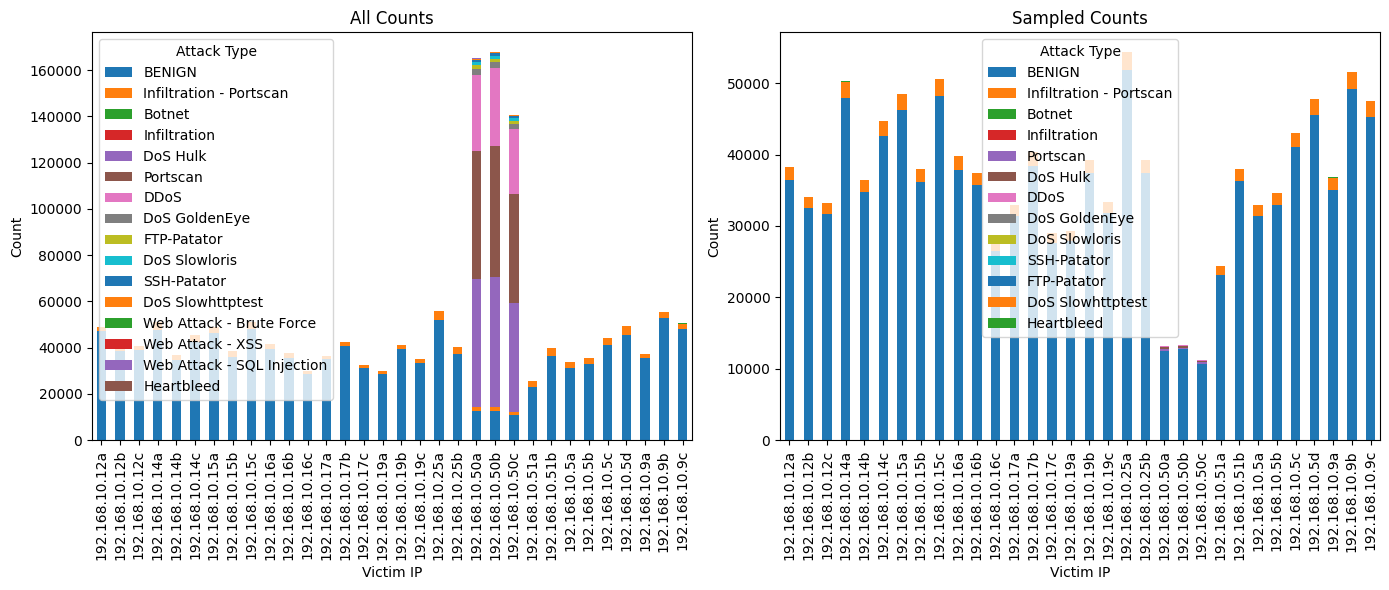

In [6]:
new_victim_IP = new_victim_df["Dvc Label"].value_counts().keys()
new_victim_IP = new_victim_IP.sort_values()
all_counts = pd.DataFrame()
sampled_all_counts = pd.DataFrame()
for curr_ip in new_victim_IP:
    curr_ip_df = new_victim_df.loc[new_victim_df["Dvc Label"] == curr_ip]
    counts = curr_ip_df["Label"].value_counts()
    counts.name = curr_ip
    all_counts = pd.concat([all_counts, counts], axis=1)
    
    sampled_curr_ip_df = sample_df(curr_ip_df, anomaly_rate=0.05)
    counts = sampled_curr_ip_df["Label"].value_counts()
    counts.name = curr_ip
    sampled_all_counts = pd.concat([sampled_all_counts, counts], axis=1)
        
all_counts = all_counts.T
all_counts.sort_index(inplace=True)
sampled_all_counts = sampled_all_counts.T
sampled_all_counts.sort_index(inplace=True)


# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Correct subplot usage

# Plot on the first subplot
all_counts.plot(kind='bar', stacked=True, ax=ax[0], title='All Counts')
ax[0].set_xlabel("Victim IP")
ax[0].set_ylabel("Count")
ax[0].legend(title="Attack Type")

# Plot on the second subplot
sampled_all_counts.plot(kind='bar', stacked=True, ax=ax[1], title='Sampled Counts')
ax[1].set_xlabel("Victim IP")
ax[1].set_ylabel("Count")
ax[1].legend(title="Attack Type")

plt.tight_layout()
plt.show()


<Figure size 100x200 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Frequency of Each Label in Dataset')

(array([0]), [Text(0, 0, 'count')])

<Figure size 100x200 with 0 Axes>

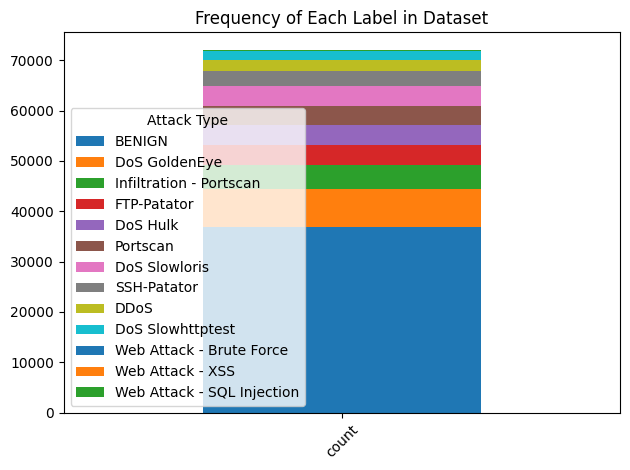

In [7]:
new_atk_df = new_victim_df.loc[(new_victim_df["Dvc Label"] == "192.168.10.50a") | 
                               (new_victim_df["Dvc Label"] == "192.168.10.50b") |
                               (new_victim_df["Dvc Label"] == "192.168.10.50c")]
benign_df = new_atk_df[new_atk_df["Label"] == "BENIGN"].sample(frac=1.0, random_state=42)
misc_atk_df = new_atk_df.loc[(new_atk_df["Label"] != "DDoS") &
                             (new_atk_df["Label"] != "DoS Hulk") &
                             (new_atk_df["Label"] != "Portscan") &
                             (new_atk_df["Label"] != "BENIGN") ].sample(frac=1.0, random_state=42)

common_atk_df = new_atk_df.loc[(new_atk_df["Label"] == "DDoS") |
                             (new_atk_df["Label"] == "DoS Hulk") |
                             (new_atk_df["Label"] == "Portscan") |
                             (new_atk_df["Label"] == "BENIGN") ].sample(frac=1.0, random_state=42)

new_atk_df = pd.concat([benign_df, misc_atk_df, common_atk_df[:benign_df.shape[0] - misc_atk_df.shape[0]]])

label_counts = new_atk_df["Label"].value_counts()
label_counts_df = pd.DataFrame(label_counts).T
# Plotting
plt.figure(figsize=(1, 2))
label_counts_df.plot(kind='bar', stacked=True)
plt.title('Frequency of Each Label in Dataset')
plt.xticks(rotation=45)
plt.legend(title="Attack Type")
plt.tight_layout()
plt.show()

## Performace New Attack

In [8]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling

def lm_eval_2(Xgmm_test_dvc, gm_pred, lm_clf):
    train_perc = 0.6
    Xlm_train, Xlm_test, ylm_train, ylm_test = train_test_split(Xgmm_test_dvc, 
                                                        gm_pred, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=gm_pred, 
                                                        random_state=42)    
    if lm_clf == "Comittee":
        # initializing Committee members
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):

            # initializing learner
            learner = ActiveLearner(
                estimator=RandomForestClassifier(),
                X_training=Xlm_train, y_training=ylm_train,
            )
            learner_list.append(learner)        
        lm_clf = Committee(learner_list=learner_list)
        predictions = lm_clf.predict(Xlm_test)    
    else:
        # Train the classifier on the training data
        lm_clf.fit(Xlm_train, ylm_train)    
        
        predictions = lm_clf.predict(Xlm_test)

        
    # Evaluate accuracy
    accuracy = accuracy_score(ylm_test, predictions)
    print(f"Accuracy: {accuracy}")
    return accuracy, lm_clf, Xlm_train, ylm_train
# Read the csv and clean it
def train_gm(Xgm_train_scaled, y_train, supervision_rate, model):

    # Prepare labels for semi-supervised learning
    idx = np.where(y_train == 1)[0]
    y = np.zeros_like(y_train.values)
    y = set_supervised_label(supervision_rate, y, idx)
    # Train the model
    path = f"gm_1_{supervision_rate}.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            clf = pickle.load(f)
    else:
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=Xgm_train_scaled.to_numpy(), y=y_train)  
            
            # with open(path, 'wb') as f:
                # pickle.dump(clf, f)
    return clf
def train_lm(victim_IP, Xgmm_test, y_test, scaler, gm_clf,lm_clf, method = "Normal"):
    # Load Model Instead      
    # dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
    #                 'Dst Port', 'Timestamp', 'Dvc Label']            
    # Create a fresh copy of the DataFrame for each IP and supervision rate
    roc_auc, curr_X_test_scaled, gm_pred, gm_opt_threshold = perform_inference(Xgmm_test, y_test, dropping_cols, scaler, gm_clf)
    print(f"gm_opt_threshold is {gm_opt_threshold}")
    acc, updated_lm_clf, Xlm_train, Ylm_train = lm_eval_2(curr_X_test_scaled, gm_pred, lm_clf)
    return updated_lm_clf, gm_opt_threshold, Xlm_train, Ylm_train



# Perform New Attack Classification using Local Model (Obtain)
def new_attacks_inference(lm_clf, Xnew_train, ynew_train, scaler):

        cart_predictions = lm_clf.predict(Xnew_train)
        # Evaluate accuracy
        accuracy = accuracy_score(ynew_train, cart_predictions)
        print(f"Accuracy before update: {accuracy}")
        
        # Get Confidence Point
        # Get the indices of the samples where the actual label doesn't match the predicted label
        mismatch_indices = [i for i, (actual, cart_predictions) in enumerate(zip(ynew_train, cart_predictions)) if actual != cart_predictions]

        uncertain_count = 0
        cart_probabilities = lm_clf.predict_proba(Xnew_train)

        return accuracy, cart_probabilities, mismatch_indices 

def active_learning_query(lm_clf, Xnew_train, ynew_train, scaler):
    pass
    #Use Stream-Based Sampling, however instead of 1 by 1, get the whole pool

        # X_pool = Xnew_train.copy()
        # y_pool = ynew_train.copy()
        # for idx in range(n_queries):
        #     query_idx, query_instance = lm_clf.query(X_pool)
        #     lm_clf.teach(
        #         X=X_pool[query_idx].reshape(1, -1),
        #         y=y_pool[query_idx].reshape(1, )
        #     )
        #     performance_history.append(lm_clf.score())
        #     # remove queried instance from pool
        #     X_pool = np.delete(X_pool, query_idx, axis=0)
        #     y_pool = np.delete(y_pool, query_idx)     
        # predictions = lm_clf.predict(X_pool)     
        
    

# Forward Low confidence data to GM and Label (Get GM Accuracy)
def get_low_confidence_data(cart_probabilities, mismatch_indices, threshold=1):
    if threshold == 1:
        forward_gm_idx = np.where((cart_probabilities[:, 0] != threshold) & (cart_probabilities[:, 0] !=  threshold))
    else: 
        forward_gm_idx = np.where((cart_probabilities[:, 0] > threshold) & (cart_probabilities[:, 0] <  1-threshold))
    print(f"Total Uploaded Data {len(forward_gm_idx[0])}")
    # How many Misclassified data is inconfident
    set_mismatch_indices = set(list(mismatch_indices))
    set_forward_gm_idx = set(forward_gm_idx[0].tolist())
    x = len(set_mismatch_indices.intersection(set_forward_gm_idx))
    print(f"Percentage of misclassied data that is uploaded: {x/len(mismatch_indices)}")
    print(f"Total Data Uploaded: {len(forward_gm_idx[0])/len(cart_probabilities)}")
    # print(f"Correctly Detected / Uploaded data: {(x/len(forward_gm_idx[0]))}")  
    return forward_gm_idx

# Upload to label and Perform Training on CART_Classifier
def upload_gm(X_forward, y_forward, gm_clf, lm_clf, gm_opt_threshold, orig_Xlm_train, orig_Ylm_train):
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    initial_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, initial_gm_pred)
    print(f'Accuracy of GM before update: {accuracy}')
    
    # Convert numpy arrays to DataFrames
    X_forward_df = pd.DataFrame(X_forward, columns = orig_Xlm_train.columns )
    y_forward_df = pd.DataFrame(np.zeros(initial_gm_pred.shape[0]), columns=["Label"])

    # Concatenate with original DataFrames
    Xtrain = pd.concat([pd.DataFrame(orig_Xlm_train), X_forward_df], axis=0)
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), y_forward_df])
    Xtrain.columns = orig_Xlm_train.columns
    # return Xtrain, Ytrain
    # Update GM
    gm_clf = train_gm(orig_Xlm_train, orig_Ylm_train, supervision_rate, PReNet)
    # Inference using updated GM
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    updated_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, updated_gm_pred)
    print(f'Accuracy of GM after update: {accuracy}')  
    
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), pd.DataFrame(updated_gm_pred, columns=["Label"])])  
    lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1)
    # continued_model.fit(X_forward_df, y_forward_df, xgb_model=lm_clf.get_booster())    
    # continued_model.fit(Xtrain, Ytrain)
    lm_clf.fit(Xtrain, Ytrain)
    return lm_clf
# Evaluate Accuracy with new attack data
def eval_updated_lm(Xnew_test, ynew_test, new_lm_clf):
    pred = new_lm_clf.predict(Xnew_test)
    acc = accuracy_score(ynew_test, pred)
    print(f'Accuracy of updated LM: {acc}')


### Scenario 2

In [9]:
victim_IP = new_victim_IP
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]

model = PReNet
model.random_state = 42
supervision_rate = 0.05
anomaly_rate = 0.05
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']


In [10]:
supervision_rate = 0.01
model = PReNet
model.random_state = 42

Xgm_train, Xgmm_test, y_train, y_test, scaler = process_dataset(new_victim_df, anomaly_rate)
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
Xgm_train.drop(dropping_cols, axis = 1, inplace = True)     

Xgm_train_scaled = scaler.fit_transform(Xgm_train)
Xgm_train_scaled = pd.DataFrame(Xgm_train_scaled, columns=Xgm_train.columns)    

# gm_clf = train_gm(Xgm_train_scaled, y_train, supervision_rate, model)

In [11]:
Y_new = new_atk_df["Label"].map({"BENIGN":0}).fillna(1)
X_new = new_atk_df.drop(columns = dropping_cols+["Label"], axis=1, inplace=False)
X_new_scaled = scaler.transform(X_new)
train_perc = 0.7
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new_scaled, 
                                                    Y_new, 
                                                    test_size=1 - train_perc, 
                                                    shuffle=True, 
                                                    stratify=Y_new, 
                                                    random_state=42)  
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)

## Active Learning for data upload selection

In [12]:
Xlm = Xgmm_test.copy()
ylm = y_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     

Xlm_scaled = scaler.fit_transform(Xlm)
Xlm_scaled = pd.DataFrame(Xlm_scaled, columns=Xlm.columns)  
lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
lm_clf, gm_opt_threshold, Xlm_train, Ylm_train = train_lm(new_victim_IP, Xlm_scaled, y_test, scaler, gm_clf, lm_clf)

# gm_opt_threshold is 2.594822645187378
# Accuracy: 0.9839122424732192

NameError: name 'gm_clf' is not defined

### Uploading All

In [ ]:
accuracy, probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
threshold = 0.0
forward_gm_idx = get_low_confidence_data(probabilities, mismatch_indices, threshold)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xgm_train_scaled, y_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

### Uploading Select (CART)

In [ ]:
Y_new = new_atk_df["Label"].map({"BENIGN":0}).fillna(1)
X_new = new_atk_df.drop(columns = dropping_cols+["Label"], axis=1, inplace=False)
X_new_scaled = scaler.transform(X_new)
train_perc = 0.7
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new_scaled, 
                                                    Y_new, 
                                                    test_size=1 - train_perc, 
                                                    shuffle=True, 
                                                    stratify=Y_new, 
                                                    random_state=42)  
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)
accuracy, cart_probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
  
forward_gm_idx = get_low_confidence_data(cart_probabilities, mismatch_indices)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xlm_train, Ylm_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

### Uploading Select XGBoost

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

Xlm = Xgmm_test.copy()
ylm = y_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     

Xlm_scaled = scaler.fit_transform(Xlm)
Xlm_scaled = pd.DataFrame(Xlm_scaled, columns=Xlm.columns)  
lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, 
                       learning_rate=0.1)
lm_clf, gm_opt_threshold, Xlm_train, Ylm_train = train_lm(new_victim_IP, Xlm_scaled, ylm, scaler, gm_clf, lm_clf)

# calibrated_probabilities = calibrated_clf.predict_proba(X_test)
# gm_opt_threshold is 2.594822645187378
# Accuracy: 0.9839122424732192

In [ ]:
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)
accuracy, probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
threshold = 0.1
forward_gm_idx = get_low_confidence_data(probabilities, mismatch_indices, threshold)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xgm_train_scaled, y_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

### Alipy for Active Learning

In [ ]:
lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
lm_clf.fit(Xnew_test, ynew_test)
pred = lm_clf.predict(Xnew_test)
accuracy_score(pred, ynew_test)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

0.9719647822057461

In [ ]:
Xlm = Xgmm_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     
Xlm_scaled = scaler.fit_transform(Xlm)
ylm = y_test.copy()

Xcomb = np.concatenate([Xlm_scaled, X_new_scaled], axis=0)
ycomb = np.concatenate([ylm, Y_new], axis=0)

lab_idx = len(Xlm_scaled)



In [ ]:
ylm.values

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:


X_known = Xlm_scaled # Known Data
y_known = ylm.values
# X = X_new_scaled # Pool Data
# y = Y_new.values

X = np.concatenate([Xlm_scaled, X_new_scaled], axis=0)
y = np.concatenate([ylm, Y_new], axis=0)

alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None)

# Split data
alibox.split_AL(test_ratio=0.3, initial_label_rate=0.001, split_count=4)

model = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)

def main_loop(alibox, strategy, round, threshold = None):
    # Get the data split of one fold experiment
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

    # Set initial performance point
    # X_temp_train = np.concatenate([X_known, X[label_ind.index, :]], axis=0)
    # y_temp_train = np.concatenate([y_known, y[label_ind.index]], axis=0)    
    model.fit(X=X[label_ind,:], y=y[label_ind])
    pred = model.predict(X_new_scaled)
    accuracy = alibox.calc_performance_metric(y_true=Y_new.values,
                                                y_pred=pred,
                                                performance_metric='accuracy_score')
    
    queries_accuracy = [accuracy]
    new_accuracy_list = [accuracy]
    informative_score_list = []

    # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.
    for i in range(5):
        print(strategy, i)
        print("Performed Inference")
        unlab_ind = np.array(unlab_ind)
        if "QueryInstanceRandom" in str(strategy):
          select_ind = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, model = model, batch_size=1000, custom = True)
        else:
          select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, model = model, custom = True)
          informative_score_list.append(informative_score)
        print("Select ...")
        if threshold == None:
          label_ind = np.concatenate([label_ind, select_ind])# label_ind.update(select_ind)
          mask = np.where(np.isin(unlab_ind, select_ind, invert=True)) # unlab_ind.difference_update(select_ind)
          unlab_ind = unlab_ind[mask]
          print(f"Shape of Label_ind: {np.shape(label_ind)}")
          
        else:
          select_ind = np.where(np.array(informative_score) > threshold)[0][:]
          print(np.shape(select_ind))
          label_ind = np.concatenate([label_ind, select_ind])# label_ind.update(select_ind)
          mask = np.where(np.isin(unlab_ind, select_ind, invert=True)) # unlab_ind.difference_update(select_ind)
          unlab_ind = unlab_ind[mask]          
          

        # Update model and calc performance according to the model you are using
        model.fit(X=X[label_ind,:], y=y[label_ind])
        
        print("Fit Model ...")
        pred = model.predict(X[test_idx,:])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                    y_pred=pred,
                                                    performance_metric='accuracy_score')
        print("Calculate Accuracy ...")
        new_pred = model.predict(X_new_scaled)
        new_accuracy = accuracy_score(Y_new.values, new_pred)
        queries_accuracy.append(accuracy)
        # Save intermediate results to file
        # st = alibox.State(select_index=select_ind, performance=accuracy)
        # saver.add_state(st)
        
        new_accuracy_list.append(new_accuracy)
        # Passing the current progress to stopping criterion object
        # stopping_criterion.update_information(saver)
    # Reset the progress in stopping criterion object
    # stopping_criterion.reset()
    return informative_score_list, queries_accuracy
    # return queries_accuracy, new_accuracy_list

NameError: name 'Xlm_scaled' is not defined

### Training based on data importance threshold

In [ ]:
for round in range(1):
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

    # Use pre-defined strategy
    unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")
    qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")
    # eer = alibox.get_query_strategy(strategy_name="QueryExpectedErrorReduction")
    rnd = alibox.get_query_strategy(strategy_name="QueryInstanceRandom")
    # lal = alibox.get_query_strategy(strategy_name="QueryInstanceLAL", cls_est=100, train_slt=False)
    # lal.download_data()
    # lal.train_selector_from_file(reg_est=500, reg_depth=25)

    query_unc_result, new_unc_result = main_loop(alibox, unc, round, threshold = 0.5)
    query_qbc_result, new_qbc_result = main_loop(alibox, qbc, round, threshold = 0.5)
    # eer_result.append(copy.deepcopy(main_loop(alibox, eer, round)))
    query_rnd_result, new_rnd_result = main_loop(alibox, rnd, round)
    # query_lal_result, new_lal_result = main_loop(alibox, lal, round, threshold = 0.015)
# query_result_df = pd.DataFrame({
#     "unc_result": query_unc_result,
#     "qbc_result": query_qbc_result,
#     "rnd_result": query_rnd_result,
#     # "lal_result": query_lal_result,
# })
new_result_df = pd.DataFrame({
    "unc_result": new_unc_result,
    "qbc_result": new_qbc_result,
    "rnd_result": new_rnd_result,
    # "lal_result": new_lal_result,
})

<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 0
Performed Inference
Select ...
(38655,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 1
Performed Inference
Select ...
(5083,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 2
Performed Inference
Select ...
(3214,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 3
Performed Inference
Select ...
(3214,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceUncertainty object at 0x7fcd26c68760> 4
Performed Inference
Select ...
(3214,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.query_labels.QueryInstanceQBC object at 0x7fcd26e48160> 0
Performed Inference
Select ...
(46152,)
Fit Model ...
Calculate Accuracy ...
<alipy.query_strategy.

Text(0.5, 1.0, 'UNC Informative Score Distribution')

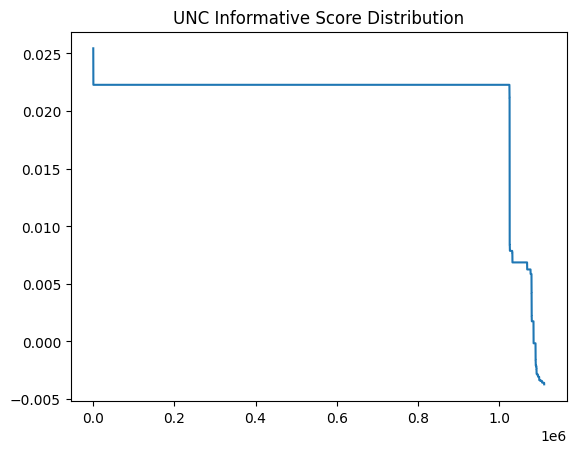

In [ ]:
informative_arr = np.array(query_lal_result[4][:])
informative_arr = -np.sort(-informative_arr)

plt.plot(np.arange(len(informative_arr)), informative_arr)
plt.title("UNC Informative Score Distribution")

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Performance')

Text(0.5, 1.0, 'Active Learning Results')

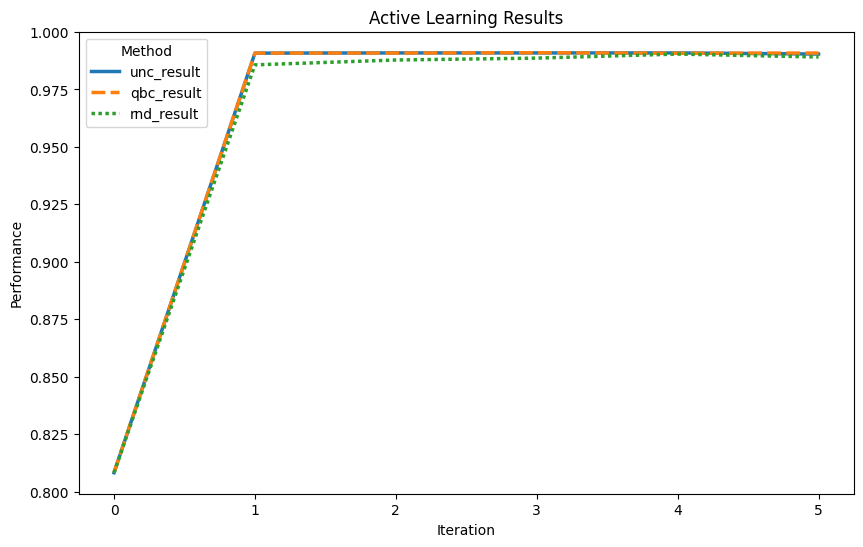

In [ ]:
# Plot the DataFrame
queried_data = pd.DataFrame({
    "unc_result": [41135, 6604, 6627, 673, 5943],
    "qbc_result": [35954, 20398, 4858, 4723, 7874],
    "rnd_result": [10778, 20778, 30778, 40778, 50778],
})
plt.figure(figsize=(10, 6))
sns.lineplot(data=new_result_df, palette='tab10', linewidth=2.5)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Performance')
plt.title('Active Learning Results')
plt.legend(title='Method', loc='best')

# Show the plot
plt.show()

# Real World Active Learning Simulation

In [ ]:
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
anomaly_rate = 0.05
Xrw_train, Xrw_test, yrw_train, yrw_test, scaler = process_dataset(new_victim_df, anomaly_rate, train_perc=0.8)
Xrw_train.drop(columns=dropping_cols, axis=1, inplace=True)
Xrw_train_scaled = scaler.transform(Xrw_train)
Xrw_test_scaled = Xrw_test.drop(columns=dropping_cols, axis=1, inplace=False)
Xrw_test_scaled = scaler.transform(Xrw_test_scaled)
yrw_train = yrw_train.values
yrw_test = yrw_test.values

<function round(number, ndigits=None)>

### Scenario 1

In [ ]:

# def get_curr_batch(X_full, y_full, n_batch, orig_size):
#   dvc_labels = X_full["Dvc Label"]
#   train_size = int(orig_size/n_batch)
#   # X_curr_batch_df, X_remaining_df, y_curr_batch_df, y_remaining_df = train_test_split(X_full, y_full, train_size=train_size, stratify=dvc_labels)
#   train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
#   return X_curr_batch_df, X_remaining_df, y_curr_batch_df, y_remaining_df
def select_data(strategy, label_ind, test_idx, model, batch_size, threshold):
    if "QueryInstanceRandom" in str(strategy):
      select_ind = strategy.select(label_index=label_ind, unlabel_index=test_idx, model = model, batch_size=batch_size, custom = True)
    else:
      select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=test_idx, model = model, custom = True)
      # print(len(informative_score))
      
    if threshold == None:
      label_ind = np.concatenate([label_ind, select_ind])# label_ind.update(select_ind)
      
      # print(f"Shape of Label_ind: {np.shape(label_ind)}")
    else:
      select_ind = np.where(np.array(informative_score) > threshold)[0]
      batch_size = min(batch_size, np.shape(select_ind)[0] ) #Limit up to 30 000 per query
      label_ind = np.concatenate([label_ind, select_ind[:batch_size]])# label_ind.update(select_ind)
      print(f"Added {batch_size} Shape of Label_ind: {np.shape(label_ind)}")  
      return label_ind, informative_score
    
def batch_train(X, y, strategy, round, X_test, y_test, label_ind, model, metric = roc_auc_score, threshold = None ):
    informative_score = []
  
    _, test_idx, idx, _ = alibox.get_split(round)
    unlab_idx = np.concatenate([test_idx, idx], axis=0)
    # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.

    batch_size = 10000 
    label_ind, informative_score = select_data(strategy, label_ind, unlab_idx, model, batch_size, threshold)
    # Update model and calc performance according to the model you are using
    model.fit(X=X[label_ind,:], y=y[label_ind])
    
    pred = model.predict(X_test)
    query_accuracy = metric(pred, y_test)
    return informative_score, query_accuracy, label_ind, model
    

def evaluate_new_atk(X, y, strategy, X_test, y_test, label_ind, unlabel_ind, model, metric, threshold):

    _, _, _, unlab_ind = alibox.get_split(0)
    
    
    batch_size = 10000  
    label_ind, informative_score = select_data(strategy, label_ind, unlabel_ind, model, batch_size, threshold)
    model.fit(X=X[label_ind,:], y=y[label_ind])
    pred = model.predict(X_test)
    query_accuracy = metric(pred, y_test)   
      

    return informative_score, query_accuracy, label_ind, model   
    
  
def evalute_all_dvc(full_ip, X_test, y_test, model,scaler, metric, curr_round, metrics_dict): 

  for ip in full_ip:
    X_curr_ip = X_test.loc[X_test["Dvc Label"] == ip].copy()
    X_curr_ip.drop(columns=dropping_cols, axis=1, inplace=True)
    X_curr_ip_scaled = scaler.transform(X_curr_ip)
    pred = model.predict(X_curr_ip_scaled)
    score = metric(pred,y_test[X_curr_ip.index])
    metrics_dict['metric'][ip][curr_round] = score
  return metrics_dict
# plot_graph_scenario(metrics_dict, queries_iter = [0,1,5])
    
def plot_supporting_scores(informative_score_list, n_times=10, sort=True):

    
    fig, axes = plt.subplots(5, 2, figsize=(14, 14))  # Create 5x2 subplots
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(n_times):
      informative_arr = np.array(informative_score_list[i])
      if sort:
        informative_arr = -np.sort(-informative_arr)      
        axes[i].plot(np.arange(len(informative_arr)), informative_arr)
        axes[i].set_title(f"Informative Score Distribution of new attack scenario {i + 1}")

    plt.tight_layout()
    plt.show()
    

In [ ]:
# Full
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix
np.random.seed = 4022

alibox = ToolBox(X=Xrw_train_scaled, y=yrw_train, query_type='AllLabels', saving_path=None)
alibox.split_AL(test_ratio=0.99, initial_label_rate=0.001, split_count=10)
round = 10
metric = f1_score
_, _, initial_label_ind, _ = alibox.get_split(0)
round = 10
metrics_dict = {
    'metric': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP}
}      

unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")
# qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")
# rnd = alibox.get_query_strategy(strategy_name="QueryInstanceRandom")
# lal = alibox.get_query_strategy(strategy_name="QueryInstanceLAL", cls_est=100, train_slt=False)
# lal.download_data()
# lal.train_selector_from_file(reg_est=500, reg_depth=25)    

lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)

lm_clf.fit(Xrw_train_scaled[initial_label_ind,:], yrw_train[initial_label_ind])

initial_acc = metric(lm_clf.predict(Xrw_test_scaled), yrw_test)

informative_score_list = []
unc_queries_accuracy = [initial_acc]
# qbc_queries_accuracy = [initial_acc]
# rnd_queries_accuracy = [initial_acc]
# lal_queries_accuracy = [initial_acc]

unc_label_size = [np.shape(initial_label_ind)[0]]
# qbc_label_size = [np.shape(initial_label_ind)[0]]
# rnd_label_size = [np.shape(initial_label_ind)[0]]
# lal_label_size = [np.shape(initial_label_ind)]

unc_label_ind = qbc_label_ind = rnd_label_ind = lal_label_ind = initial_label_ind
for i in range(round):
  unc_informative_score, unc_query_accuracy, unc_label_ind, model = batch_train(Xrw_train_scaled, yrw_train, 
                                                                    unc, i, Xrw_test_scaled, yrw_test, 
                                                                    unc_label_ind, lm_clf, metric, threshold=0.2)
  informative_score_list.append(unc_informative_score)
  unc_queries_accuracy.append(unc_query_accuracy)
  unc_label_size.append(np.shape(unc_label_ind)[0])
  metrics_dict = evalute_all_dvc(new_victim_IP, Xrw_test, y_test, model,scaler, metric, curr_round, metrics_dict)
# for i in range(round):
#   qbc_informative_score, qbc_query_accuracy, qbc_label_ind = batch_train(Xrw_train_scaled, yrw_train, 
#                                                       qbc, i, Xrw_test_scaled, yrw_test, 
#                                                       qbc_label_ind, lm_clf, metric, threshold=0.2)
#   qbc_queries_accuracy.append(qbc_query_accuracy)
#   qbc_label_size.append(np.shape(qbc_label_ind)[0])
# for i in range(round):
#   rnd_informative_score, rnd_query_accuracy, rnd_label_ind = batch_train(Xrw_train_scaled, yrw_train, 
#                                                       rnd, i, Xrw_test_scaled, yrw_test, 
#                                                       rnd_label_ind, lm_clf, metric, threshold=None)
#   rnd_queries_accuracy.append(rnd_query_accuracy)
#   rnd_label_size.append(np.shape(rnd_label_ind)[0])
  
# for i in range(round):
#   lal_informative_score, lal_query_accuracy, lal_label_ind = batch_train(Xrw_train_scaled, yrw_train, 
#                                                       lal, i, Xrw_test_scaled, yrw_test, 
#                                                       lal_label_ind, lm_clf, metric, threshold=0.0050)      
#   lal_queries_accuracy.append(lal_query_accuracy)
#   lal_label_size.append(np.shape(lal_label_ind)[0])

# ！！！ TODO Use Other Algorithms


([array([ 18887,  25846, 106213, ...,  22528, 170265,   3114]),
  array([ 81907,  69745, 116219, ..., 139020,  76520,  99517]),
  array([105855, 101373,  78952, ..., 160250,  71087,  84128]),
  array([177132, 105381,  41591, ..., 178295, 123642, 131560]),
  array([107875,  26516, 175570, ..., 100436,  13410,  12752]),
  array([176804,  44533,  62905, ...,   5534, 158396, 144552]),
  array([  6382, 143726, 149848, ...,  25843, 154927, 138206]),
  array([ 12420, 143645,  95512, ..., 154078, 116080,  55223]),
  array([ 74937,  57961, 144845, ..., 143768, 117557, 159426]),
  array([142961,   1116,  37481, ..., 135422,  95053, 123656])],
 [array([ 97907, 130090, 141286, ...,   4854, 105272, 160859]),
  array([ 56632,  37395, 105381, ..., 146895,  85330,  69731]),
  array([141281, 144545,  28425, ..., 123476,  21453, 109057]),
  array([ 92223, 167864,  60079, ...,  24622,  34735,  42629]),
  array([109599,   5120, 149792, ...,  45765,  15125,  21114]),
  array([ 62197, 150338, 161261, ..., 1

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 10000 Shape of Label_ind: (10002,)


NameError: name 'curr_round' is not defined

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix
np.random.seed = 4022
alibox = ToolBox(X=Xrw_train_scaled, y=yrw_train, query_type='AllLabels', saving_path=None)
alibox.split_AL(test_ratio=0.99, initial_label_rate=0.001, split_count=10)
# Define ToolBox for New Attacks

metric = f1_score
_, xx, initial_label_ind, _ = alibox.get_split(0)
strategy_name = "QueryInstanceQBC"
strategy = alibox.get_query_strategy(strategy_name=strategy_name)
# qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")



lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)

lm_clf.fit(Xrw_train_scaled[initial_label_ind,:], yrw_train[initial_label_ind])

initial_acc = metric(lm_clf.predict(Xrw_test_scaled), yrw_test)

informative_score_list = []
unc_queries_accuracy = [initial_acc]

unc_label_size = [np.shape(initial_label_ind)[0]]

unc_label_ind = qbc_label_ind = rnd_label_ind = lal_label_ind = initial_label_ind
for i in range(round):
  unc_informative_score, unc_query_accuracy, unc_label_ind, model = batch_train(Xrw_train_scaled, yrw_train, 
                                                                    strategy, i, Xrw_test_scaled, yrw_test, 
                                                                    unc_label_ind, lm_clf, metric, threshold=0.1)
  informative_score_list.append(unc_informative_score)
  unc_queries_accuracy.append(unc_query_accuracy)
  unc_label_size.append(np.shape(unc_label_ind)[0])
  metrics_dict = evalute_all_dvc(new_victim_IP, Xrw_test, y_test, model, scaler, metric, i, metrics_dict)




([array([127866, 136910,  88369, ...,  26958,  51050,  10054]),
  array([ 41192, 155717,  88696, ...,  10972,  21485, 151719]),
  array([175168,  63346,  53010, ..., 156931, 143350, 132878]),
  array([146368,  80502, 181316, ..., 178950, 149114,  75878]),
  array([ 75022, 179063, 182515, ...,  24067,  16242,  75325]),
  array([130714, 105537,  76924, ..., 119713, 168913,  77567]),
  array([ 63535, 150769, 182050, ..., 116976,  44094,  44577]),
  array([ 40510, 171260,  86290, ..., 181346, 157201,  66296]),
  array([162387,  26817, 144360, ..., 109755, 135301,   3916]),
  array([179529,  98767, 153703, ...,  18521,  54696, 116983])],
 [array([ 51304, 161052,  63212, ...,  44561,  71140,  13732]),
  array([ 23139,   3553, 114435, ...,  23511,  45276, 172103]),
  array([  3253,   5054,  75155, ...,  42892,  21076, 120670]),
  array([159083,  74216,   5745, ...,  88430, 147311,  12080]),
  array([ 49139, 100488,    104, ...,  58687, 102790, 115400]),
  array([ 77563, 139740, 164424, ...,  

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 10000 Shape of Label_ind: (10002,)
Added 1377 Shape of Label_ind: (11379,)
Added 1909 Shape of Label_ind: (13288,)
Added 1342 Shape of Label_ind: (14630,)
Added 2199 Shape of Label_ind: (16829,)
Added 1609 Shape of Label_ind: (18438,)
Added 1566 Shape of Label_ind: (20004,)
Added 1171 Shape of Label_ind: (21175,)
Added 2231 Shape of Label_ind: (23406,)
Added 1317 Shape of Label_ind: (24723,)


In [ ]:

X_known = Xrw_train_scaled[unc_label_ind]
y_known = yrw_train[unc_label_ind]
X_new_scaled_train, X_new_scaled_test, y_new_train, y_new_test = train_test_split(X_new_scaled, Y_new, shuffle=True, test_size=0.2,
                                                                                  stratify=Y_new, random_state=4022)
X = np.concatenate([X_known, X_new_scaled_train])
y = np.concatenate([y_known, y_new_train])
new_label_ind = np.arange(len(X_known))
new_unlab_ind = np.arange(len(X_known), len(X))
alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None, )
alibox_new.split_AL(test_ratio=0.001, initial_label_rate=0.001, split_count=1)
new_strategy = alibox_new.get_query_strategy(strategy_name=strategy_name)

unc_informative_score, unc_query_accuracy, unc_label_ind, model = evaluate_new_atk(X, y, new_strategy, X_new_scaled_test, 
                                                                                   y_new_test, new_label_ind, new_unlab_ind, 
                                                                                   model, metric, threshold = 0.1)
informative_score_list.append(unc_informative_score)
unc_queries_accuracy.append(unc_query_accuracy)
unc_label_size.append(np.shape(unc_label_ind)[0])

([array([ 2627, 20868, 79576, ..., 76546, 74475, 17585])],
 [array([21627, 16542, 74356, 15606, 12449,   730, 12340, 67966, 12905,
         30485, 53587, 80252, 31659, 18461, 30370, 26694, 29186, 28426,
         40087, 62872, 19871, 54481, 60319, 15998, 43035, 34428, 22962,
         35269, 41755, 26463, 25475,  9282, 34112, 52503, 57511, 70284,
         80625, 35994, 61867, 47177, 33991, 78042, 40361, 74437, 47763,
         19705, 34025, 16553, 58407,  8850, 62506,   761, 28781, 74453,
         70061, 77330, 35423, 71908, 61931, 30775, 19905, 20614, 26923,
         22682, 74793, 69705, 67257, 51836, 43793, 32545,  4699,  5542,
          6307,   703, 28697, 58303,  4402, 15777, 25305,  5747, 28068,
          8309])],
 [array([ 2627, 20868, 79576, 70449, 72719, 52826, 58673, 61719, 51194,
          3593, 51922, 74438, 38499, 80147,  9503, 32797, 53816, 39654,
         59317, 80888, 49377, 44972, 32239, 51054, 28682, 51525, 32253,
         73844, 71177, 65202,  5085,  6446,  8842, 22310, 

Added 10000 Shape of Label_ind: (34723,)


In [ ]:
unc_query_accuracy

0.9530774800868935

<Axes: >

Text(0.5, 1.0, 'Result DataFrame')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Performance')

<Axes: >

Text(0.5, 1.0, 'New Result DataFrame')

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Performance')

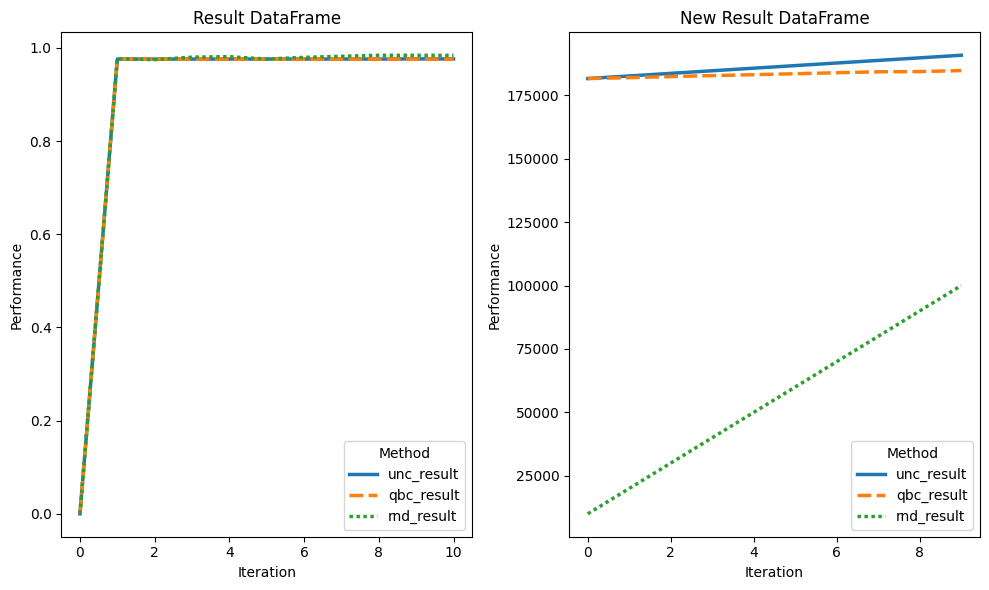

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.lineplot(data=result_df,ax=ax[0], palette='tab10', linewidth=2.5)

ax[0].set_title('Result DataFrame')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Performance')
ax[0].legend(title='Method', loc='best')

sns.lineplot(data=size_df, ax=ax[1], palette='tab10', linewidth=2.5)
ax[1].set_title('New Result DataFrame')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Performance')
ax[1].legend(title='Method', loc='best')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

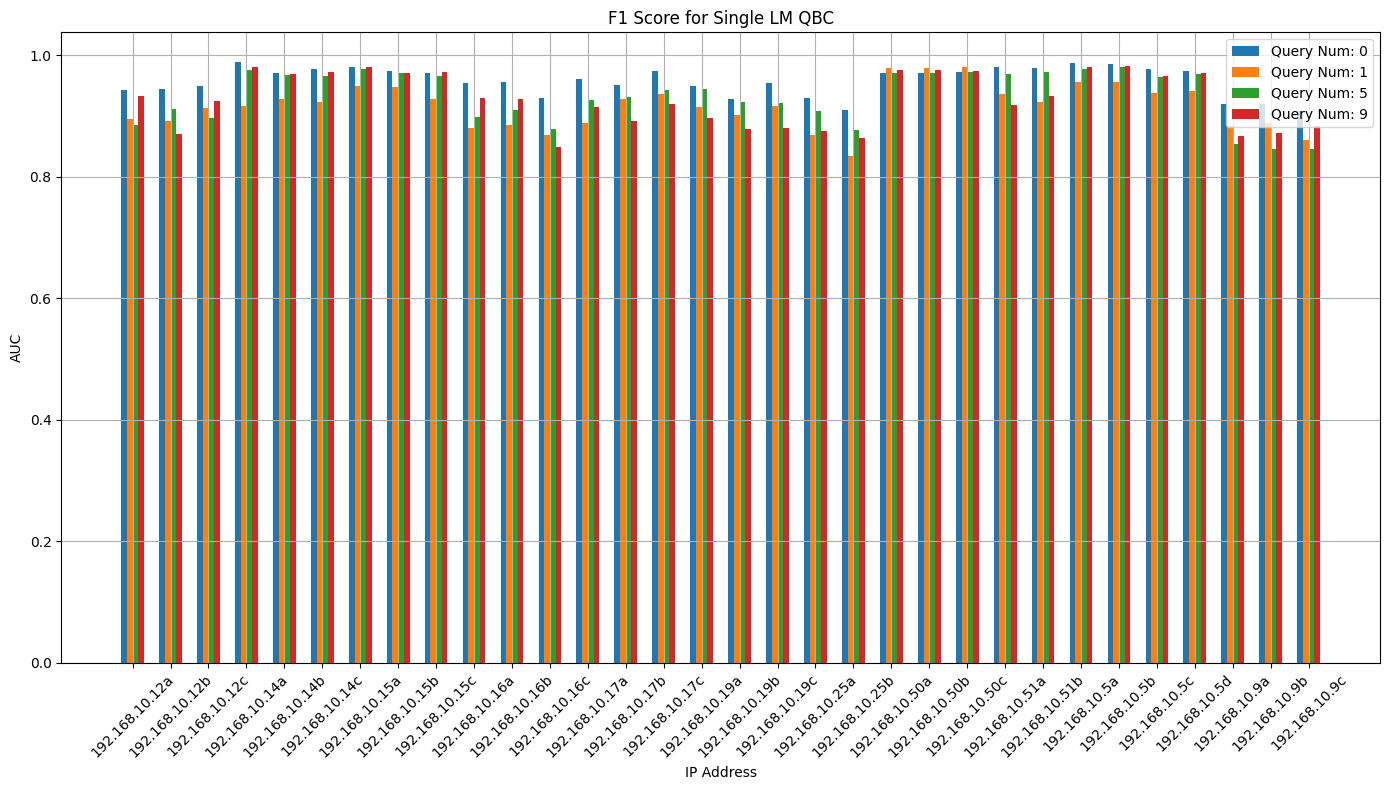

0.928143005651566

In [ ]:
plot_graph_scenario(metrics_dict, queries_iter = [0,1,5,9], title="F1 Score for Single LM QBC")
metric_values = []

for ip in metrics_dict['metric']:
    metric_values.append(metrics_dict['metric'][ip][9])

average_metric = np.mean(metric_values)
average_metric

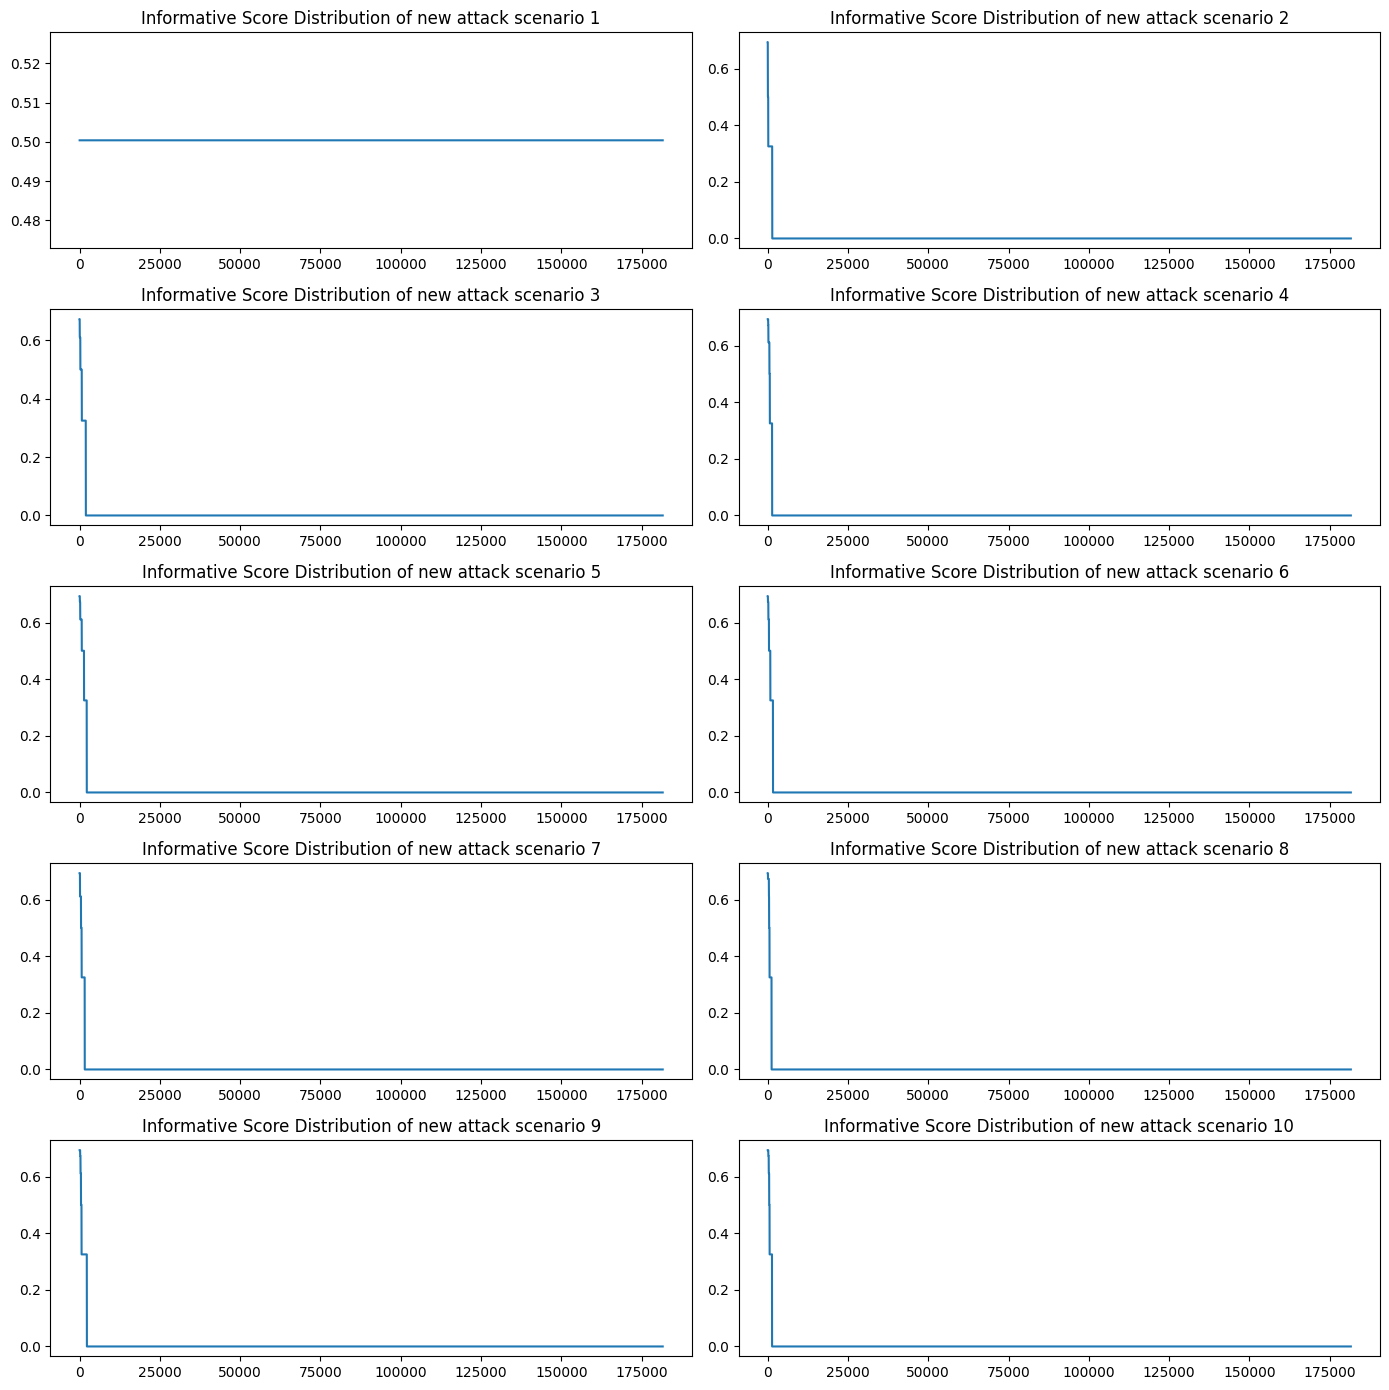

In [ ]:
plot_supporting_scores(informative_score_list, n_times=10)

Text(0.5, 1.0, 'Label Size Per Query')

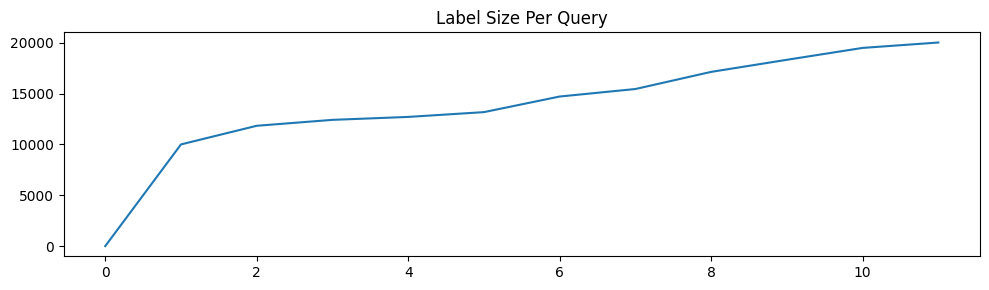

In [ ]:
informative_arr = np.array(informative_score_list[0])
informative_arr = -np.sort(-informative_arr)
fig, ax = plt.subplots(1,1, figsize=(10,3))


ax.plot(np.arange(len(unc_label_size)), unc_label_size)
ax.set_title("Label Size Per Query")
plt.tight_layout()
plt.show()


In [ ]:
unc_label_size

[2, 10002, 11406, 12652, 14677, 16590, 18506, 20568, 20821, 21076, 21514]

### Scenario 2

In [ ]:
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
anomaly_rate = 0.05
Xrw_train, Xrw_test, yrw_train, yrw_test, scaler = process_dataset(new_victim_df, anomaly_rate, train_perc=0.8)

Xrw_train.drop(columns=dropping_cols, axis=1, inplace=True)
Xrw_train_scaled = scaler.transform(Xrw_train)
Xrw_test_scaled = Xrw_test.drop(columns=dropping_cols, axis=1, inplace=False)
Xrw_test_scaled = scaler.transform(Xrw_test_scaled)
yrw_train = yrw_train.values
yrw_test = yrw_test.values
round = 10
metrics_dict = {
    'metric': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP},
    'informative_score': {ip : {query : [] for query in range(round)} for ip in new_victim_IP},
    'size': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP}
}      

In [ ]:
for ip in new_victim_IP:
  # Get Current IP and Split into training testing
  # X_curr_ip = Xrw_train.loc[Xrw_train["Dvc Label"] == ip].copy()
  # X_curr_ip.drop(columns=dropping_cols, axis=1, inplace=True)
  # X_curr_ip_scaled = scaler.transform(X_curr_ip)  
  # X_curr_train, X_curr_test, y_curr_train, y_curr_test = train_test_split(X_curr_ip_scaled, Y_new, shuffle=True, test_size=0.2,
  #                                                                                 stratify=Y_new, random_state=4022)
  curr_ip_df = new_victim_df.loc[new_victim_df["Dvc Label"] == ip].copy()
  X_curr_train, X_curr_test, y_curr_train, y_curr_test, _ = process_dataset(curr_ip_df, anomaly_rate = 0.05, train_perc=0.8)
  X_curr_train_scaled, X_curr_test_scaled = X_curr_train.drop(columns=dropping_cols, axis=1, inplace=False), X_curr_test.drop(columns=dropping_cols, axis=1, inplace=False),

  X_curr_train_scaled, X_curr_test_scaled = scaler.transform(X_curr_train_scaled), scaler.transform(X_curr_test_scaled)
  y_curr_train, y_curr_test = y_curr_train.values, y_curr_test.values
  # Set Data Split for 10 batches
  alibox = ToolBox(X=X_curr_train_scaled, y=y_curr_train, query_type='AllLabels', saving_path=None)
  alibox.split_AL(test_ratio=0.99, initial_label_rate=0.1, split_count=10)
  strategy_name = "QueryInstanceUncertainty"
  strategy = alibox.get_query_strategy(strategy_name=strategy_name)
  _, x, label_ind, _ = alibox.get_split(0)
  
  lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
  metric = f1_score

  lm_clf.fit(Xrw_train_scaled[initial_label_ind,:], yrw_train[initial_label_ind])
  initial_acc = metric(lm_clf.predict(Xrw_test_scaled), yrw_test)
  informative_score_list = []
  queries_accuracy = [initial_acc]
  label_size = [np.shape(initial_label_ind)[0]]  
  for i in range(10):
    informative_score, query_accuracy, label_ind, model    = batch_train(X_curr_train_scaled, y_curr_train, 
                                  strategy, i, X_curr_test_scaled, y_curr_test, label_ind, lm_clf, metric, threshold = 0.1 )
    metrics_dict['metric'][ip][i] = query_accuracy
    metrics_dict['size'][ip][i] = len(label_ind)
    metrics_dict['informative_score'][ip][i] = informative_score

([array([2162, 2015, 1204, 1599, 1961, 1555, 5717, 2156, 1405, 1766, 1357,
         3381, 3634, 2154, 3652, 2186, 3406, 1776, 3257, 1445, 4372, 4725,
         4604, 4554, 1262, 5387,  856, 2081, 5146,  725, 1585, 4549, 2866,
         1687, 1878, 2780, 5074, 5276, 5394,  796, 5501, 4164, 3436, 4771,
         1223,  879, 3189, 4143, 4239, 4922,  215, 5058, 3107, 1451, 1729,
         3335, 3439]),
  array([5644, 2632, 2585, 1578, 1603, 5114, 5568, 3444, 2365,  475, 5430,
         5322, 1396, 5613, 5560, 5153, 3255, 1878, 5144, 5177, 5477, 2513,
         1361, 4158, 1352, 2226, 1653, 1719, 4126, 4346, 3210, 4773, 4512,
         2359,  702,  112, 3684,  119, 1477, 3101, 4387, 4562, 2220, 1905,
         4577, 3279, 2380, 2714, 3805, 3704, 4000, 5522, 1571,  852, 1172,
         4023, 4266]),
  array([2955, 5144, 1224, 5146, 5611, 5275, 1514, 5121, 1554, 3822, 3092,
         2815, 1276,  315, 1889,  150, 5142, 5351, 5203, 3877, 4202, 5579,
         5325, 4007, 4131, 4438, 3898,  212, 4374, 160

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 64 Shape of Label_ind: (1070,)
Added 64 Shape of Label_ind: (1134,)
Added 63 Shape of Label_ind: (1197,)
Added 64 Shape of Label_ind: (1261,)
Added 63 Shape of Label_ind: (1324,)
Added 63 Shape of Label_ind: (1387,)
Added 94 Shape of Label_ind: (1481,)
Added 68 Shape of Label_ind: (1549,)
Added 65 Shape of Label_ind: (1614,)


([array([ 605, 2314, 3388, 4601, 2698,  423, 4258, 1372, 3204,  650, 1046,
         5090, 4595, 5084, 1981, 4608, 1904, 1126, 2753, 4896, 1554, 3000,
         3999, 2452, 5044, 3129, 4024, 3599, 1295,  387,  508, 3709, 1391,
         4823,  572,  920, 2944, 3479, 2216, 2657, 4936, 3612, 2922, 2853,
         4294, 3822, 3002, 1984, 3547, 2005, 4102]),
  array([4503, 3863, 1304,  391, 1612, 1929, 3224, 4161,  429, 3113, 3472,
         4101,  588,  259, 4945,  931, 4251, 3687,  549, 3956, 1716, 4086,
         3232,  819, 4436, 1415, 2982, 2984, 1516, 4188, 3651, 4877, 2020,
         1741, 1418, 4609, 1555, 1033, 4627, 4649, 1963, 4906, 3865,  387,
         1375, 2865, 3292, 2684,   15, 4342,   12]),
  array([ 637, 4529, 1184, 3734, 4881, 1651, 1578, 1346,  253, 3717, 2352,
         1043, 2674, 1775, 3370, 4192, 2464, 1568, 2666, 4606,  706, 2717,
         4177, 3926,  604, 2076, 2689, 3458,  169,  387, 1680, 3485, 4448,
         1459,  986, 4983, 4240, 2487, 1463, 2880, 1252, 4683, 3374, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1005,)
Added 205 Shape of Label_ind: (1210,)
Added 159 Shape of Label_ind: (1369,)
Added 58 Shape of Label_ind: (1427,)
Added 58 Shape of Label_ind: (1485,)
Added 69 Shape of Label_ind: (1554,)
Added 69 Shape of Label_ind: (1623,)
Added 24 Shape of Label_ind: (1647,)
Added 23 Shape of Label_ind: (1670,)
Added 24 Shape of Label_ind: (1694,)


([array([1572, 1779, 3908, 1321, 4350,  962, 1736, 3100,  455, 1565,  989,
         1886,   61, 3642, 2946, 3352, 4342, 3876, 4867, 3449, 4674, 1826,
           99, 4526, 2571, 4245, 1827, 1521,  969, 4594, 4955, 3195, 1957,
         4976, 3982, 4596, 2740, 1901, 2780, 1892, 2424, 1441,  759,  263,
         1213, 4252,  345, 1594,  280, 3892]),
  array([1098, 2605, 2578, 4296, 4390, 1001, 1193, 3094, 1427, 3764,  312,
         4469, 1518, 4472, 1813,  822, 1471, 4248, 3715, 1726, 4047, 1607,
         4638,   57, 2126, 3028,   59, 4571, 3543,  229, 2641, 2448, 3317,
          234, 2246, 1204, 2622,  326,  237, 1402,  196, 1473, 4860, 1869,
         3730, 1494, 4151, 1889, 3995, 2379]),
  array([2260, 1445, 3324, 3631, 2444, 4457, 2464, 1342, 2651,  728, 1979,
         3804, 2304, 3369,  275, 3380, 1557, 1663,  988, 3223, 2601, 3033,
          639, 2106, 2469, 1000, 1388, 1277, 4374, 2426, 3951,  951, 4580,
          188, 4892, 2200, 3978, 1213, 4787, 4730, 1150, 3655, 2128,  881,
      

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1005,)
Added 125 Shape of Label_ind: (1130,)
Added 112 Shape of Label_ind: (1242,)
Added 86 Shape of Label_ind: (1328,)
Added 86 Shape of Label_ind: (1414,)
Added 84 Shape of Label_ind: (1498,)
Added 161 Shape of Label_ind: (1659,)
Added 33 Shape of Label_ind: (1692,)
Added 38 Shape of Label_ind: (1730,)
Added 37 Shape of Label_ind: (1767,)


([array([3796, 1184,  488, 6053, 7333, 3191, 5899, 7502, 6001, 2831, 5561,
         3535, 1327, 4291, 1003, 3181, 3082, 4903, 6284, 6256, 7170, 5231,
         5181, 5460,  474, 3487, 5620, 6844,  791, 4807, 6125, 7284, 2203,
          750, 3946, 3509, 5875, 4122, 5095, 7412, 4683, 2344, 2051, 4069,
         4183, 3640, 5965, 2037, 5302, 6793, 3208, 5148, 6979, 4239, 2402,
         6500, 3262, 7091, 5892,  461,  767,  710, 2197, 7128, 4525, 4471,
         5358, 4393, 4702, 2079,  807, 3152, 6274, 6547, 3919]),
  array([4836, 7291, 3588, 4550, 4838, 7067, 5531, 5612, 2208,   17, 6139,
         7128, 4178, 2706, 7455, 2097, 1641, 1925, 4804, 1557,  117, 5862,
         2696, 3387,  946, 5147, 4934, 5741, 6008, 4219, 5671, 4697, 2128,
         7307, 7450,  589, 1687, 1327, 7448, 2321, 4995, 4992,  404, 4128,
          979, 6570, 2551, 6254, 5687, 7485, 6666, 5802, 1323, 4205, 1122,
         6436,  428, 5467, 3896, 4422, 3389, 3300, 1258, 2229, 6735,  864,
         1683, 1949, 3564, 6644, 66

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1008,)
Added 204 Shape of Label_ind: (1212,)
Added 176 Shape of Label_ind: (1388,)
Added 164 Shape of Label_ind: (1552,)
Added 164 Shape of Label_ind: (1716,)
Added 217 Shape of Label_ind: (1933,)
Added 110 Shape of Label_ind: (2043,)
Added 110 Shape of Label_ind: (2153,)
Added 89 Shape of Label_ind: (2242,)
Added 89 Shape of Label_ind: (2331,)


([array([5284, 4993, 4730, 2378, 5398,  870, 1243, 3868, 3894, 3764, 2152,
         3357, 1642,  971, 2119,  450, 1228,  942, 3516,  546, 4164,  589,
         4394, 4923, 2646, 3722, 5079, 2984, 2495, 1062,  987, 4251, 2627,
         5055, 3623, 4711, 3135, 3452, 1305, 2867, 1328, 2508,  177, 1706,
         3360, 4187, 1529, 4733,  484, 1234, 4413, 4518,  595, 5220, 3644]),
  array([2803, 3822, 4554, 3801, 5216, 3533,  821, 1943, 2214, 3502, 2696,
         2418, 2741, 2825, 4204,  785, 3357, 2395,  350, 4918, 3036,   94,
          119, 4947, 4923, 2668, 4669,  138, 4313, 3596, 3162, 3169,  331,
         5249, 3608, 3969,  194, 3587,   19, 1328, 2198,  917, 2169, 2057,
         1655, 3013, 2429,  957, 2683, 2246, 4071, 3453, 1638, 4642, 2771]),
  array([2276, 2150, 4240, 4918, 1758, 2204, 5299, 4370, 5297, 1644, 4294,
          764, 3134, 3427, 3669, 1137,  638, 3786, 1611, 1896, 4653, 2771,
         1304, 4831, 4424, 3886, 1576, 3620, 3186, 3978, 2707, 1266,   97,
         1856, 3081, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 48 Shape of Label_ind: (1054,)
Added 48 Shape of Label_ind: (1102,)
Added 46 Shape of Label_ind: (1148,)
Added 46 Shape of Label_ind: (1194,)
Added 47 Shape of Label_ind: (1241,)
Added 47 Shape of Label_ind: (1288,)
Added 46 Shape of Label_ind: (1334,)
Added 47 Shape of Label_ind: (1381,)
Added 47 Shape of Label_ind: (1428,)


([array([6286, 5616,   59,  388, 2760, 6355,  499, 3886, 5366, 5081, 2289,
         4526, 5388, 3837, 3941, 4962, 4933, 2033, 5356, 2693, 1070, 1691,
         4084,  447, 6000, 4874, 2650, 5720, 4479, 3642, 3901, 5141, 3978,
          168, 4180, 3417, 1766, 2702, 2321,  582, 5334,  532, 3187, 1639,
         1925, 4700, 3275, 6604, 5498, 6504, 1572, 5060, 5670, 3382, 1865,
         1160, 3567, 4333, 6218, 1459, 3463, 4182,  687, 3802, 1155, 3820,
         6475]),
  array([ 501, 3714, 5888, 2443, 3424,  855,  289, 1931, 4264, 5706, 1301,
         2538, 3770, 3933,  315,  127, 6624, 5617, 5072, 5523, 2154, 4172,
         5199, 6599, 1203, 5989, 4682, 4748, 6275, 3669, 5739,  222, 4870,
         1962, 3808, 2765,  578, 1588, 6593, 5571, 5054, 3658,  720, 3931,
         4115, 2119, 3316, 1288,  984, 5789, 3864, 2150,  640, 5137, 3565,
          728, 3120, 2346, 3163, 6622, 1426, 3596, 2382, 5551,  508, 1223,
         5949]),
  array([3626, 1583, 4948, 3092, 2216, 6655, 4319, 3001, 5297,  24

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1007,)
Added 50 Shape of Label_ind: (1057,)
Added 49 Shape of Label_ind: (1106,)
Added 50 Shape of Label_ind: (1156,)
Added 50 Shape of Label_ind: (1206,)
Added 45 Shape of Label_ind: (1251,)
Added 45 Shape of Label_ind: (1296,)
Added 171 Shape of Label_ind: (1467,)
Added 170 Shape of Label_ind: (1637,)
Added 149 Shape of Label_ind: (1786,)


([array([1385, 6691, 4726, 6793, 6671, 2420, 6946, 5525, 1973,  311, 3498,
         5437,  947, 1643, 6293, 3490, 6668, 5603, 6860, 6475, 1166, 4824,
         5919, 2766, 3104, 5143, 2304, 1952, 4898, 5541, 5443,  949, 2322,
         1204, 4713, 6837, 1329, 2800, 5566, 6550, 6878, 4061, 3484, 1644,
         4597,  362, 3687, 3455, 5321, 2563, 4679,  907, 2075, 4099, 1178,
         6992,  963, 2917, 6773, 1819, 5386, 4881, 4828, 3146, 1038, 3318,
         3062, 6228, 5784, 6081, 4107, 3514, 6365]),
  array([1464, 6303, 3678, 7024, 6654, 5092, 1067, 4452, 3433, 5353, 1337,
         4443, 3604, 7229,  952, 6463, 6980, 4058, 4116, 5405, 7034, 2040,
         6631, 6859,  653,  836, 7099, 5239, 7154, 6657, 3879, 2895, 5861,
         2530, 2442, 4166, 4487, 5516, 4895, 4615, 4931, 5743,  882, 1607,
         6145, 7261, 4337, 1106,  994, 4630, 3451, 3214, 2657, 4730, 3656,
         2966, 4921,  398, 6772, 5749, 1362, 5635, 4312, 4004, 4918, 2719,
         3580, 2956,  932, 4935, 5309,  856, 17

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1007,)
Added 165 Shape of Label_ind: (1172,)
Added 166 Shape of Label_ind: (1338,)
Added 49 Shape of Label_ind: (1387,)
Added 49 Shape of Label_ind: (1436,)
Added 49 Shape of Label_ind: (1485,)
Added 49 Shape of Label_ind: (1534,)
Added 49 Shape of Label_ind: (1583,)
Added 49 Shape of Label_ind: (1632,)
Added 167 Shape of Label_ind: (1799,)


([array([5211, 1148, 5481,  846, 4707, 3227,  330, 2137, 4836, 2586, 3781,
         3803, 2946, 4852, 1648, 3201, 4297, 2232, 3330, 1333, 5069, 4863,
         2452, 4773, 5034, 2311, 5093, 4690,  693, 1014,  862, 3188, 1068,
          814, 5451, 4388, 4540, 3060, 1553, 1837, 2613, 3263, 1136, 2352,
         3235,   37, 1549,  251, 2184, 2006, 1743, 1601, 3881, 2695, 2279,
         5071,   96]),
  array([ 788, 3014, 2833, 4746,   44, 1512,  199, 5588, 5030, 3732, 4281,
         3020, 2327, 4357, 5021, 4297, 4024, 5250, 3070, 3955, 4533,  833,
         1167,  178, 5579, 5438, 1172, 2818,  532, 4985, 3570, 2811, 2669,
         3992, 1327, 5181, 5665, 4489, 5584, 1722, 5606,  314, 4778, 3790,
         3927, 3272, 5530, 2812, 1833,   61,  326, 1300, 4498, 5086, 1850,
         2703, 5517]),
  array([ 817, 4834, 2935, 3336, 5476,  196, 1088,  296, 1161, 4360,   81,
          320,  724, 1256, 2676, 3833,  332, 4992,  755, 5136, 3715, 4478,
          983, 4189, 4765, 3378,  261,  624, 4327, 379

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)


([array([6010, 4282, 4710, 3753, 1679,  994,  193, 1256, 7084, 5129, 4437,
         7241, 2496, 7527,  966, 6115, 6008, 1041, 3002,  517, 6279, 1595,
         1213,  582, 2801, 5438, 3748, 6645, 3765, 4919, 5499, 5758, 2818,
          284, 2829, 5922, 1796, 3856, 6048,   44, 7113, 1733,  813, 6380,
         5218, 3957, 4024, 1224, 1623,  716, 4147, 1053, 1201, 5755, 6449,
         2380, 5533, 2789, 7360, 1130, 1325, 4884, 6088, 3217, 5299, 5009,
         5281, 4254, 3725, 5778, 7342, 1115, 5854, 3777, 2677, 7005]),
  array([ 214, 2820, 2904, 4345, 2430, 4564,   65, 5370, 3669,  178, 6556,
          241, 1292, 1623, 6822, 6359, 5678, 6003, 6791, 6107, 7377,    8,
         3325, 1866, 5289, 6962, 6747,  843, 1478, 1924, 2919, 6700, 4425,
          697, 5270, 6388, 6797, 1419, 3889, 3605, 2147, 5647, 1734, 2261,
         1510, 2622, 6919, 2248, 1616, 5785, 5944, 1974, 5780, 1815, 4819,
         1417, 4548, 5220, 2510, 2680,   27, 3288, 3123, 6926, 6426, 7521,
          194, 6274, 2967, 74

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1008,)
Added 72 Shape of Label_ind: (1080,)
Added 72 Shape of Label_ind: (1152,)
Added 69 Shape of Label_ind: (1221,)
Added 68 Shape of Label_ind: (1289,)
Added 66 Shape of Label_ind: (1355,)
Added 68 Shape of Label_ind: (1423,)
Added 65 Shape of Label_ind: (1488,)
Added 59 Shape of Label_ind: (1547,)
Added 59 Shape of Label_ind: (1606,)


([array([4738, 4619, 4408, 2959, 2326, 3480, 3174, 5864, 4019, 3510, 1913,
         1052, 4429, 1784, 3051, 1962, 1401, 3816, 3158, 5334, 1872, 5009,
         1648, 4305, 5449, 4010,  377, 2736, 2918, 2191, 3608, 2507, 2229,
           92, 5054, 1544, 1517, 4398, 2196, 3723, 3708, 1606, 2591,  630,
         1752, 3734, 3010, 1248,  668, 3211, 5405, 2246, 2882, 4272, 1017,
         4038, 2339, 3251, 2907,  255]),
  array([4235, 1591, 1546,  857, 3647,  728,  821, 1812, 3126, 2785, 2086,
          235, 5428, 3978, 1930, 1607, 1187,  344, 3426, 1777, 3040, 2332,
          616, 2358, 4465,  401, 4562, 2703, 4795, 1973, 5620, 2793, 1791,
          559, 3264,  968, 2274,  641, 4470, 3474,   91,    6, 3838, 5513,
         5740,  710, 4774, 5041,  623, 5710, 5356,  817,   50, 2861, 5302,
         1287,  471, 2664, 3323, 4720]),
  array([1339, 2035, 3341, 4740,  687, 2808, 1038, 1649,  801, 3875, 1233,
         1784, 4392, 5817, 5427,  486,  849, 5871, 1890, 2060, 3989, 2261,
         4689, 306

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)


([array([3790, 3236, 4092,   82, 5022, 4412, 4218,  622, 1493, 4553, 2382,
          628,  737, 4996, 2342, 2850, 2167, 3498, 1527, 3413, 2792, 2743,
         3646, 3532, 4277, 3071, 2972, 2936, 2376, 2849, 2027, 1945, 2060,
         1769, 2556, 4373, 2317, 5075, 1018, 5295, 5327, 4443, 5389, 2977,
         1895, 4661, 2815, 1185, 2783, 5216, 3750, 2572, 2091, 3161, 3521,
         4779]),
  array([2989,  587, 2687, 5452, 2508, 2947,  318,  813, 2301, 4123,  322,
         1796, 2399, 3541, 4754, 5524, 4287, 1366, 3768,  261, 2031, 1688,
          589,  887, 2645, 2203, 2622, 3792, 2636, 3716, 4020,   57, 3150,
         1775, 3776, 3432, 4523, 5371, 2877, 5087, 5178, 4109, 3695, 3821,
         4658, 2437, 4487, 2458, 1890, 2748,  166,  618,  859, 4013, 5488,
         2122]),
  array([4103, 2687, 2704, 4384, 3506, 2966,  643,  708, 1720, 3815, 3107,
         2196, 1129,  385, 4031, 5476, 2413, 3048, 5113,  951, 5001, 2180,
         2053,  436, 3109, 3170,  183,  597,  993, 4153, 2653, 192

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)
Added 0 Shape of Label_ind: (1006,)


([array([1245, 1985,  545, 2069, 1228, 2434, 2489, 2352, 4149, 1115,  614,
           46, 2456, 2920, 1271,   33, 3006,  105,   81,  532, 1557, 3814,
         2360, 3048,  701,  893, 2397,  616, 2451, 3841, 2838, 3187, 2487,
         2781, 1219, 1541, 3690, 3259, 2547, 1087, 3109, 2390]),
  array([2080, 3076, 2663,   57, 1943, 2714,   59, 3456, 3602, 4046, 3469,
         3954, 2266, 1725, 3201, 1728, 2987, 3364, 2270, 1298, 3455, 2092,
         3730, 1368, 4089,  369, 1167,  577, 2182, 2718, 1554, 1543, 2802,
         1305, 1713, 3336, 1747, 3483, 1881, 3450,  486,  771]),
  array([2393, 1422, 3268, 1112, 2067,  686, 2973, 1026, 1489, 3050, 1038,
         2357, 3305, 2417, 1619, 3146, 2944, 1088,  297, 3021, 2448, 3084,
         2188, 1980, 3237, 2794,  480, 1023,  357, 2972, 2443, 3117, 1681,
         2654, 1266,  932, 1130,  979, 3782, 1873, 3540, 1518]),
  array([3855, 1908, 3128, 3347, 1335, 1585,  322,  228, 3055, 3615, 1101,
         3620, 3767, 1951, 3976, 2987,  909, 3393, 2100

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1004,)
Added 206 Shape of Label_ind: (1210,)
Added 191 Shape of Label_ind: (1401,)
Added 78 Shape of Label_ind: (1479,)
Added 73 Shape of Label_ind: (1552,)
Added 72 Shape of Label_ind: (1624,)
Added 53 Shape of Label_ind: (1677,)
Added 41 Shape of Label_ind: (1718,)
Added 40 Shape of Label_ind: (1758,)
Added 40 Shape of Label_ind: (1798,)


([array([4172,  154, 1053, 2830,  503,  784, 3137, 2479, 3396, 2695, 1748,
         2163, 1618, 4825, 2631,  715, 3460, 3868, 4824, 4614, 4319, 4225,
          442, 2605, 1863,  269,  759, 3448, 4676,  517, 4868, 4854, 4843,
         4508,  656, 1681,  857, 2429, 2549,   17, 4462, 1912, 2600, 1372,
         1247,  478, 1036, 1401, 3180]),
  array([4882, 1546,  737, 3346, 4164, 3935, 4003, 1318, 1064, 4776,  986,
         3586, 1266,  915, 2187, 3347, 3628, 2674, 1088,  519, 2082, 3064,
         1107, 2494, 2010, 1083, 3725, 4593, 1760, 2746, 1671, 2526, 3607,
         4540, 3667, 4481,  459, 1103,  389, 2676, 1789,  307, 1281, 1945,
         4066,  349, 2081, 2158, 1093]),
  array([2168, 2378, 2459, 4253, 4199, 4560, 2884, 2276, 2114, 1093,  107,
         3817, 3638, 4035, 2009, 1243, 3471, 1244,  244,  925, 4043, 3036,
         3943,   70, 3129, 3176,  135, 2802,  187,  174, 3791, 3712,  362,
          547, 4101,  545, 2608, 1427,  775, 4574, 2993, 2738, 2400, 4095,
         4863, 224

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1005,)
Added 156 Shape of Label_ind: (1161,)
Added 152 Shape of Label_ind: (1313,)
Added 146 Shape of Label_ind: (1459,)
Added 143 Shape of Label_ind: (1602,)
Added 139 Shape of Label_ind: (1741,)
Added 76 Shape of Label_ind: (1817,)
Added 75 Shape of Label_ind: (1892,)
Added 76 Shape of Label_ind: (1968,)
Added 72 Shape of Label_ind: (2040,)


([array([5041, 1478, 2538,  971,  233, 1636, 4776, 6049, 1526, 1585,  123,
         4011, 5366, 5401,  474, 2503, 4468,  431,  111,  945, 2847, 4952,
          445, 1591, 5917,  714,  572, 4136, 3306, 4255, 3418,  106, 5265,
          165, 1868, 2608, 2130, 4549, 5160, 2956, 1003,  341,  931, 2916,
          623, 5315, 1559, 1781, 5264, 1782, 2227,  263, 3396, 5329, 5861,
         3810, 4653,  295, 3990, 3900,  766]),
  array([3658, 4528, 3858, 5242, 2534,  669,  726, 4875, 2159, 5897, 2728,
          655, 1142, 4958, 5300, 4925,  979, 2447, 1135, 3643, 3742,   75,
         1310, 1995, 2817, 5556, 5489, 3254, 1284, 4164, 3095, 4428,  605,
         1483, 5188, 3177, 1640, 5835, 2059, 3688, 5370, 2833, 5532, 4525,
          127, 5889, 2698, 4461, 4187, 5167, 4288, 3428, 2026,  385, 2135,
          903, 5520, 5285, 5974, 1140, 2818]),
  array([2569, 3546,  743, 2958, 5144, 2686, 4160, 4074, 1301, 2210, 5002,
         5628, 4081,  669, 5716, 4901,  346, 1915, 4008, 5001, 5045, 3759,
      

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 237 Shape of Label_ind: (1243,)
Added 213 Shape of Label_ind: (1456,)
Added 164 Shape of Label_ind: (1620,)
Added 163 Shape of Label_ind: (1783,)
Added 165 Shape of Label_ind: (1948,)
Added 136 Shape of Label_ind: (2084,)
Added 135 Shape of Label_ind: (2219,)
Added 119 Shape of Label_ind: (2338,)
Added 105 Shape of Label_ind: (2443,)


([array([2601, 2765,  954,  558, 3306, 2435, 3196, 2737, 2002, 1649, 3867,
         2800, 3840,  758,  317,  489, 1414, 1763, 2579, 3534, 1301, 3270,
         3487,  321, 4191, 2284, 2161,  530,  773, 3791, 1943, 1781,   50,
         1691, 2953, 2526, 4005, 1787, 1871, 3676, 3705, 1143, 2191]),
  array([3396, 1883, 2325, 1756, 1748, 2927,  262, 3641, 1517, 2180, 3154,
         1963,  730, 2540, 1077, 2425, 2449, 3332, 3207, 4143, 1689, 1333,
         2464, 1505, 3715, 3638, 3536,  810, 1315,  761, 4047, 2734,  184,
         3550, 3198, 4053, 1030, 3505, 3731,  991, 2906, 3367, 2646]),
  array([ 327, 3005, 1868, 1101,  935, 2809, 1672, 1773, 2239,  134, 1967,
         3818, 3985,  761, 1487, 3991, 1247,  367, 1735, 1435, 1012, 1815,
         1863, 3459,  684, 3832, 1994, 2461, 4000,  491, 4234, 3466, 2699,
         2899,   38,  864, 3890, 2501, 2456,  519,   26, 3667, 4017]),
  array([1592,  746, 1842, 3346, 1337, 2650, 4239, 3098, 3688, 2482,  978,
         2391, 3281, 2799,  578, 4313

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1004,)
Added 140 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)
Added 0 Shape of Label_ind: (1144,)


([array([3241,  308,  627, 1503,  259, 2904, 3033, 1432, 1519, 1405, 2928,
         1943,  350,   81, 3313, 3410, 4198, 4340, 1292, 1355, 2592, 4108,
          411, 4036, 2002, 1985, 1566, 1148,   57, 1075, 4235, 3232, 2472,
         3723, 3148, 4094, 3754, 1606,  886,  590, 3683,  580,  988, 2671]),
  array([1573, 2163,  314, 2963,  674, 2258, 2411,  698,  347, 3569, 1694,
         2684,  501,  343, 3588, 2044, 2660, 4285, 2692, 2819, 3153, 1686,
         3937,  340, 2156, 2313, 1447, 1336,  666, 2329,  142, 3224, 1513,
         1410, 1187,  931, 1356,   91, 1277,  548,  547, 3526, 1364, 2057]),
  array([ 720,  711,  807, 2519, 2304,  995, 3186,  439, 3302, 2977, 1164,
          228, 3379, 3204, 1636, 2880, 2614, 4220, 1224, 2413, 3299, 2588,
         2419, 2755, 2474,   96,  949, 3690, 2111, 1688, 3846, 1860, 4032,
         2581, 1755,  676, 3389, 3348, 2709, 1040, 4248, 2762, 3816, 2390]),
  array([1491, 1824, 3483, 2910,  474, 2424,  960, 3878,  617, 4182,  414,
         1297, 1236

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1004,)
Added 140 Shape of Label_ind: (1144,)
Added 140 Shape of Label_ind: (1284,)
Added 139 Shape of Label_ind: (1423,)
Added 110 Shape of Label_ind: (1533,)
Added 83 Shape of Label_ind: (1616,)
Added 82 Shape of Label_ind: (1698,)
Added 82 Shape of Label_ind: (1780,)
Added 83 Shape of Label_ind: (1863,)
Added 78 Shape of Label_ind: (1941,)


([array([4083, 5706, 3792, 2417, 5866,  598,  796, 4232, 3539,  448, 2107,
          182, 2913,  776, 1037, 4407, 4142, 3686, 3914,  444, 1034,  184,
         5688, 4768, 1356, 2329, 4966, 4434, 4162, 5231,   87, 5283, 2215,
         2081, 3609, 5888, 5475, 3920, 4045, 4809, 3508,  172, 1646, 3701,
         2660,  256, 5375, 1315, 5518, 1596, 4314, 3065,   61, 1153,  583,
         1764,  877, 4034,  385]),
  array([4201, 2570, 3640, 4541, 3210, 5257, 3039,  570, 2755,  864, 4154,
         1988,  970, 1375, 2041, 4514, 3239, 4152, 2857, 1119, 1555, 5512,
         5484, 1819,  657, 2222, 4337, 4544,  350,  621, 1042, 4257, 4857,
         2488, 2547,  904,  788, 4576,   29, 4659, 2561, 3355, 2212, 4449,
         1578, 2335, 4755, 1627, 4611,  299, 2599,   26, 5884, 5645,  452,
         2180, 2464, 1358, 3108]),
  array([3769, 3610, 1709, 1248, 4076, 4205, 4786, 4184, 1743, 4636, 5434,
         2260,  989, 1267, 1302, 4715, 4171, 5250, 5693, 5006, 3084, 1428,
         2295, 5039, 5855,  31

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 141 Shape of Label_ind: (1147,)
Added 143 Shape of Label_ind: (1290,)
Added 136 Shape of Label_ind: (1426,)
Added 92 Shape of Label_ind: (1518,)
Added 92 Shape of Label_ind: (1610,)
Added 101 Shape of Label_ind: (1711,)
Added 99 Shape of Label_ind: (1810,)
Added 111 Shape of Label_ind: (1921,)
Added 147 Shape of Label_ind: (2068,)


([array([1977, 2538, 3284, 2692, 4183, 4289, 3149, 2651,  465,  147, 3032,
         4730, 1881, 1267,  702, 4710,  163,   77, 4524, 2387, 4328, 4785,
         3514, 5002, 3388, 4882, 3450,  816, 4442, 1358, 1096, 4828, 2709,
         3762, 2530,  906, 3212, 3934, 4173, 2009, 1266, 4252,  768, 2908,
          811,  657,  276,  412, 1225, 4300]),
  array([ 788, 1454, 3973, 4179, 2626, 1103, 1432,  735,  837, 1442, 2688,
         4278, 3792, 3122, 4082, 3447,  392,  191, 4901, 1397, 3960, 2711,
         1765,  943,  483, 2029,  438, 2414, 2977, 2174, 4625, 2337, 4495,
         3830, 2330, 4701, 4172, 4978, 1508,  462, 2365, 4329, 4323, 3509,
         2342, 4878, 2898, 1406,  286,  757]),
  array([1866, 4771, 2164, 2971, 1251,   56, 2316, 3910,  829, 3795, 1259,
         4610,  356,  922, 4326, 4348,  628, 2888, 4672, 1092,  186, 2626,
         4838, 4963, 4240, 4081, 4008, 2848, 4257, 1106, 1155,  175, 4907,
         2725, 2643, 2381,  956, 2456, 1338, 1981, 2238, 1348, 3705,  816,
      

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1005,)
Added 36 Shape of Label_ind: (1041,)
Added 36 Shape of Label_ind: (1077,)
Added 35 Shape of Label_ind: (1112,)
Added 36 Shape of Label_ind: (1148,)
Added 36 Shape of Label_ind: (1184,)
Added 36 Shape of Label_ind: (1220,)
Added 35 Shape of Label_ind: (1255,)
Added 34 Shape of Label_ind: (1289,)
Added 35 Shape of Label_ind: (1324,)


([array([  70, 4653,  999, 1845, 3837, 5465, 2184, 3488, 3986, 7545, 7054,
         1188, 3597,  640, 1083, 4136, 5161, 4148, 4546, 5060, 3188, 6561,
         3134, 1999,  438, 7584, 3769, 5669, 2024, 4365, 7411, 2585, 5819,
         1781, 2919, 7419, 3016, 4269, 3797, 5254, 2768, 5184, 7717, 1830,
         6172, 8093,  695, 3702, 5598, 5159, 5697, 5332, 5054, 3761, 1449,
         2147,  777, 6481, 6967, 3879, 2826, 6540, 5885, 4888, 6721, 4669,
          798, 6760, 1256, 2643, 4112, 4229, 2903, 5776, 7620, 2371, 7675,
         6270, 3401, 5724, 3159, 1002]),
  array([5374, 3701, 2101, 5225, 1443, 5759, 4350, 5399, 4321, 1784, 3422,
         5886, 7928,  384, 1350, 2234, 1461, 7247, 4460, 7117, 5644, 4592,
         1551, 7758, 1260, 8022, 5530, 2796, 5867, 2515, 6206, 2209, 5250,
         6495, 5515, 4548, 4359,  385, 1872, 7355, 4281, 7617, 4920, 7206,
          865, 6827, 8058, 8097, 6823, 7188, 1230, 3169, 3968, 1218,  923,
         5165, 3236, 2272, 1021, 1371, 7888, 2310, 6493, 62

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1008,)
Added 101 Shape of Label_ind: (1109,)
Added 78 Shape of Label_ind: (1187,)
Added 67 Shape of Label_ind: (1254,)
Added 59 Shape of Label_ind: (1313,)
Added 124 Shape of Label_ind: (1437,)
Added 51 Shape of Label_ind: (1488,)
Added 49 Shape of Label_ind: (1537,)
Added 50 Shape of Label_ind: (1587,)
Added 0 Shape of Label_ind: (1587,)


([array([3922, 5069, 5874, 4455,  703, 1066,  863, 3570, 1333, 5439,  876,
           19, 3630, 1585, 5823,  410, 2873, 4159, 4270, 3933, 5173, 2734,
          258, 1909, 4556,  236, 1495, 4041, 1480,  446, 4125, 2669, 1425,
         4623, 4785, 5695, 5728, 1210, 5409, 5854, 3040, 4679, 3160, 1230,
         2679,  975, 1683, 1598, 1469, 1474, 3215, 5308, 2880, 3240, 4730,
         5209,  982, 5170, 4462]),
  array([ 344, 5196, 4600, 4139, 4356,  947,  894, 1582, 2582, 5260, 4672,
         2974,  304, 2998, 2317,  574, 1098,  685,  126, 3789, 5614, 4947,
         3428, 2413, 1606, 4222, 2014, 1615, 3891,  993, 3190, 3197, 4904,
           28, 1384, 1682, 2423, 2603, 3798, 4551, 1055, 4887,   95, 5721,
          455,  362, 3454, 2707, 4083, 1894,  114, 2358, 1346, 1671, 1112,
         2739, 1798, 4312, 1759]),
  array([3021, 5041, 3222, 3191, 1412, 4246, 1173, 3642, 2988, 1218, 5061,
         2957, 5430, 3890, 2678, 3242, 1872, 4785, 4518, 2536, 1887, 4131,
         1392, 2296,  375, 348

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 46 Shape of Label_ind: (1052,)
Added 46 Shape of Label_ind: (1098,)
Added 45 Shape of Label_ind: (1143,)
Added 46 Shape of Label_ind: (1189,)
Added 46 Shape of Label_ind: (1235,)
Added 46 Shape of Label_ind: (1281,)
Added 45 Shape of Label_ind: (1326,)
Added 46 Shape of Label_ind: (1372,)
Added 41 Shape of Label_ind: (1413,)


([array([ 142, 1797,  758, 1099,  840,  333,   30,   22, 1199,  153,  720,
          968, 1122, 1044, 1808,  475,  208, 1565, 1035,  610]),
  array([ 563,  814, 1568, 1225, 1917, 1847,  861,   32,  387, 1472, 1284,
           37, 1547, 1435,  390, 1068,  584, 1055,  488, 1052]),
  array([1582, 1359, 1070,  846, 1283, 1399, 1456, 1014,  634,  587, 1375,
         1770, 1846,  783,  415, 1521,  166,  838,  140,  390]),
  array([ 829, 1366, 1692,  210,  193,  562,  594, 1240, 1332,  412,  554,
         1479, 1274,  488,  281,  588, 1509, 1536, 1680, 1419]),
  array([1906,   73, 1849,  151,  662, 1203, 1771, 1230,  931,  203, 1679,
          874,  132,  276,  663,  851, 1872,  699, 1005, 1209]),
  array([1176, 1762,  263, 1607, 1595, 1659,  113,  520, 1467,  722, 1361,
          841,   99,  599, 1720, 1209, 1525, 1629,  325, 1611]),
  array([ 582,  270,  968,  151, 1308, 1730,  492,  219, 1951, 1059, 1934,
          199,  648,   30, 1296,  962, 1573, 1452,  614,  630]),
  array([   6, 1392,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1002,)
Added 32 Shape of Label_ind: (1034,)
Added 34 Shape of Label_ind: (1068,)
Added 33 Shape of Label_ind: (1101,)
Added 34 Shape of Label_ind: (1135,)
Added 30 Shape of Label_ind: (1165,)
Added 27 Shape of Label_ind: (1192,)
Added 26 Shape of Label_ind: (1218,)
Added 27 Shape of Label_ind: (1245,)
Added 27 Shape of Label_ind: (1272,)


([array([1443,  344, 1141, 1040,  513, 1704, 1261, 1147,  520, 1788, 1467,
          375, 1940,  921,  196, 1442, 1376,  957,  340, 1821]),
  array([1942, 1966, 1160, 1501, 1271, 1274,  313,    6,  439,  572,  673,
          195, 1305,   77, 1011,  370,  505, 1215,  552,  917]),
  array([1357, 1517,  953,  316,  814, 1068,  497, 1850, 1533,  816, 1573,
          718, 1334,  929, 1270, 1539,   57, 1279,  288, 1017]),
  array([1152, 1647,  584, 1149, 1442,  445, 1458,  752, 1349, 1301, 1097,
          242, 1144, 1613,  337,  702,  176, 1666,  425, 1597]),
  array([1128,  463, 1690, 1646, 1762, 1457,  920,  585, 1908,  728,   98,
          570, 1398, 1898, 1333, 1850, 1491,  374,  566, 1631]),
  array([  14,  820,  643, 1286, 1822, 1453, 1933, 1420, 1429, 1067,  872,
          579,  525, 1246,  195,  821,  991, 1695,  216,    1]),
  array([1115, 1981, 1710, 1287, 1281, 1047,  172, 1625, 1140, 1773, 1619,
          266,  586,   84,  373,  268,   16, 1462, 1738, 1065]),
  array([1731, 1248,

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1002,)
Added 49 Shape of Label_ind: (1051,)
Added 43 Shape of Label_ind: (1094,)
Added 43 Shape of Label_ind: (1137,)
Added 43 Shape of Label_ind: (1180,)
Added 43 Shape of Label_ind: (1223,)
Added 43 Shape of Label_ind: (1266,)
Added 45 Shape of Label_ind: (1311,)
Added 45 Shape of Label_ind: (1356,)
Added 44 Shape of Label_ind: (1400,)


([array([ 442,  601, 1206, 1047, 1424,  791, 1231,   33, 1059,  961, 1137,
          733, 1330,  470, 1557, 1309,  432]),
  array([1171, 1601,  909, 1475,  764,  475,  586,   91, 1287,  140, 1292,
          768,  434,  110, 1645,  868, 1610]),
  array([ 164, 1270,  237, 1037, 1426, 1086, 1217,    7,  511,  393,  655,
          959, 1683,  522, 1427, 1463,  640]),
  array([ 283,  189, 1679,  193, 1247,   77,  430, 1371,  633, 1034, 1602,
          198,  252,  953, 1525, 1117, 1672]),
  array([1009, 1638, 1521,  114, 1629,  674, 1244,  911, 1147,  850,  133,
         1238, 1355,  658,  128, 1174, 1117]),
  array([1171, 1448,  757,  669, 1512,  800,  280,  568,  792,  570,  650,
          658,  960,  851, 1438,  779,  908]),
  array([ 657,  111,  140, 1449,  828,  457,  520, 1682,   40, 1325,  915,
         1630, 1507, 1323,  461, 1377, 1045]),
  array([ 503,  163,  748, 1196,  169, 1296,  267, 1467, 1456, 1572, 1099,
         1021, 1086, 1423,  294, 1261,  638]),
  array([ 227, 1474, 146

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)
Added 0 Shape of Label_ind: (1002,)


([array([ 207, 2150, 2927, 2690, 2021, 3576, 2845,  801, 1067, 1396, 2188,
          841,  887,  745, 3414, 1921, 3015, 3140, 1101, 3341, 1598, 3511,
          508, 3308,  257,  512, 2656,  879, 3057, 2714, 2127, 1936,  722,
          338, 3433,  778, 1733]),
  array([ 839, 1178,  525, 2173, 2038,  514, 3409, 1424, 1293, 1544, 2132,
         1410, 3208, 2335, 2865,  969, 2230, 2250,  806, 3593, 2399, 1392,
         1172,  942, 3643, 1493,  925, 1558,  717, 1001,  984, 3446, 2808,
         3609, 1675,  309, 2715]),
  array([ 874, 1598,  126,  384, 1908, 1065, 1685, 3592,   59,  471, 3435,
         1246, 1449, 1451, 2443, 1888, 1734, 2113,  681, 3153, 2925, 3165,
         3648, 1233, 1519, 2693, 2749, 1359, 3118,  944, 1829, 2703,  406,
         2420,  107, 1159, 1411]),
  array([ 137, 2430, 1211, 1079, 2217, 1075, 2243, 1317,  518,  829, 2644,
         1421, 1608,  579, 1278,  995, 1989, 2778, 1982, 2527, 2185, 3379,
         2259, 2755, 2414,  331, 3210, 2588, 3315, 1226, 2225, 2366, 2

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1004,)
Added 39 Shape of Label_ind: (1043,)
Added 40 Shape of Label_ind: (1083,)
Added 39 Shape of Label_ind: (1122,)
Added 40 Shape of Label_ind: (1162,)
Added 39 Shape of Label_ind: (1201,)
Added 39 Shape of Label_ind: (1240,)
Added 39 Shape of Label_ind: (1279,)
Added 39 Shape of Label_ind: (1318,)
Added 38 Shape of Label_ind: (1356,)


([array([ 395, 5182, 3435, 5345, 3612, 1156, 3272,  917, 1859, 4331,  660,
         1659, 2840, 3374, 4949, 1809, 2174, 3699, 4455, 4485, 1200, 2365,
          450, 3499, 4121, 3601, 3847, 5476,  756, 5397, 3896, 2673,  998,
         2039, 4617, 4601, 3038, 2520, 2465, 5070,  788, 4532, 5625, 2504,
         1258, 3538, 2136,  952, 5306, 1357, 2430, 2732,  806, 2084, 4519,
         3162, 3342]),
  array([  39,  916,  229, 2008, 1455,  142, 4375, 4490,  814,  966, 4731,
         5527, 2863,  241,  264, 3257, 4098, 2582, 2389, 3363, 2842, 5680,
           99, 2349, 1282, 2554, 4380, 3053, 1849, 3833,  667, 4160, 5449,
         2360,  212, 5005, 4174,  987, 2375, 4390, 1981, 2580,  877, 2188,
         1954,   21, 4639,  495,   66, 5361, 2497,  140, 4618, 3342,  466,
         1231,  177]),
  array([2817,  997, 3505,  772, 4356, 4514, 1266, 2759, 4048, 4283, 4220,
         4708, 3818, 5500,  549, 3008, 1773, 5661, 1696, 2922, 4064, 3662,
         4594, 5239, 2321, 2915, 4967, 1199, 3957, 415

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 183 Shape of Label_ind: (1189,)
Added 125 Shape of Label_ind: (1314,)
Added 138 Shape of Label_ind: (1452,)
Added 37 Shape of Label_ind: (1489,)
Added 37 Shape of Label_ind: (1526,)
Added 35 Shape of Label_ind: (1561,)
Added 37 Shape of Label_ind: (1598,)
Added 37 Shape of Label_ind: (1635,)
Added 37 Shape of Label_ind: (1672,)


([array([ 702,  618, 2868, 4749, 2835, 4089,  363,  858, 1779, 2626, 4130,
         2162, 3645, 1432, 4736, 2435, 3661, 4517, 4501,   17, 1888, 4711,
         4822, 4386, 3509, 2991, 1090, 4263, 2021, 1177,  280, 3624, 1315,
         1497, 1674, 4228, 1687, 3832, 3749, 4607, 2570, 4461,  475, 1646,
         3102, 3948, 2179, 2437,  761]),
  array([3219, 4814, 2515, 3981,  515, 3157, 1574, 3055, 4352, 2453, 4642,
          228, 1467, 2770,  969, 2418, 2483, 4576, 1430,  284, 4075, 2506,
         3318, 3122,  808, 3222, 4303, 3972, 1281, 2073, 1975, 1451,  776,
         4750, 4329,   63, 2910,  697, 3310, 4943, 2994, 2520, 2491, 4752,
          538, 1174, 3582, 4224, 4702]),
  array([3607, 4387, 4905,  575, 3364, 4122, 1022,  231, 1829, 3339, 4000,
         4469, 3862, 4289, 2287, 4153, 1051, 1070, 1663, 1142, 4568,  469,
         2207,   97, 3461, 3352, 3242, 2993,  442, 3072,  961, 1113, 3088,
           27, 4792, 3818, 4088, 4603, 2733, 3450, 2196, 4857, 2705, 1923,
         3426,   6

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1005,)
Added 156 Shape of Label_ind: (1161,)
Added 144 Shape of Label_ind: (1305,)
Added 98 Shape of Label_ind: (1403,)
Added 87 Shape of Label_ind: (1490,)
Added 87 Shape of Label_ind: (1577,)
Added 83 Shape of Label_ind: (1660,)
Added 83 Shape of Label_ind: (1743,)
Added 52 Shape of Label_ind: (1795,)
Added 53 Shape of Label_ind: (1848,)


([array([3110, 3109,  654, 2949,  262,  900,  292, 1458,  810, 1595, 1495,
         3014, 3797, 3427, 4611,  569, 2959, 1288, 3435,  969, 4412, 3388,
          390, 2955, 3595, 3601, 3507, 4207,  766,  980, 4590, 2574, 1716,
         5115, 3782, 2740, 1531,  158,  681, 1453, 1638, 4418, 4835, 4973,
         1402, 5146,  160, 1347, 3257,  797, 2531, 1899]),
  array([2250, 1361,   83,  309, 5023, 2476, 1231, 4378, 1458,  229, 1518,
         1126, 3316, 4210, 2243, 1374, 3580, 4897, 3927, 4769, 2095,  468,
         1153,  668, 4555, 2912, 2537, 2728, 3170, 4272,  622, 3542, 3147,
         2027, 3084,  913, 3284,  971,  818,  250, 1245, 1679, 4323, 4054,
          855, 4872, 2332,  647, 2865, 4634,  854, 2291]),
  array([5177,  114, 1615, 3287, 1705, 4922, 1324, 4094, 4686, 4074, 1137,
         3276, 4002, 2280, 3765, 1713, 4756,  406, 1337, 1535, 3912, 5034,
          365,  694, 4302, 1175,  688,  575,    4, 2811,  684,  849, 2907,
         4299,  276, 2741,  544,  273, 2317, 4828, 1813, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1005,)
Added 61 Shape of Label_ind: (1066,)
Added 61 Shape of Label_ind: (1127,)
Added 56 Shape of Label_ind: (1183,)
Added 56 Shape of Label_ind: (1239,)
Added 54 Shape of Label_ind: (1293,)
Added 55 Shape of Label_ind: (1348,)
Added 53 Shape of Label_ind: (1401,)
Added 54 Shape of Label_ind: (1455,)
Added 55 Shape of Label_ind: (1510,)


([array([5746, 1367, 1341,  561,  689, 2596, 5655, 5647, 5202,  961, 5270,
         6380, 4730, 1425,  774, 4604, 1184,  124, 3542, 1028, 6252, 2561,
         4918, 4693, 4887, 6201, 5162, 3639, 6073, 5589, 5863, 1294, 4578,
         2922, 5533, 1951, 1805, 5472, 5707,   92, 4021, 3415, 4759, 3038,
         2365,  461, 3536, 4945, 3417,  605, 4239,  139, 4317, 5250, 5495,
         4520,  475, 3334, 2219, 3402, 1828, 1742, 3233,  215, 6205]),
  array([ 137, 2185,  744,  369, 4341, 4705,  488, 5539, 1678, 1722, 4588,
         1993, 2608, 3168, 3233, 1588, 1162, 4268, 6446, 4466, 5518, 1679,
         5624, 2365, 2158, 5199, 6070,  199,  600,  688, 6444,  161, 5752,
         4458, 3207,  906, 3798, 1180, 3756,  910, 4614, 2753, 5315, 4424,
         5906, 2186, 1724, 3027,   60, 4214, 5278, 1580,  477,   79, 5443,
         2116, 4886, 2491, 1408,  247, 5011, 1608, 2043,  317, 1159]),
  array([4706, 6142,  219, 2754, 1390, 1649, 3676, 2920,  405, 4829, 2272,
          755, 1830, 1568, 4660, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 120 Shape of Label_ind: (1126,)
Added 197 Shape of Label_ind: (1323,)
Added 52 Shape of Label_ind: (1375,)
Added 53 Shape of Label_ind: (1428,)
Added 46 Shape of Label_ind: (1474,)
Added 46 Shape of Label_ind: (1520,)
Added 44 Shape of Label_ind: (1564,)
Added 31 Shape of Label_ind: (1595,)
Added 31 Shape of Label_ind: (1626,)


([array([3062, 4838, 5053, 3228, 6205, 6236, 1264, 5775,  814, 3801,  474,
         6249, 5423, 6179, 5477, 5279,  209, 1002, 1980, 5831, 5348, 2285,
         5094, 6996, 4690, 1689, 2309,  503, 2550, 6586, 6832,  341,  324,
         6113, 6413, 3792, 1399, 5259, 4202, 5932, 4528, 3591, 4598, 2834,
         2887, 5844, 1260, 2441, 2759, 4903, 1576, 4358, 2496, 3928, 5566,
         7032, 3601, 5066, 4162, 3746, 3906, 5709, 4723, 2032, 5924, 4776,
         3314, 2637, 5833, 3393, 6428, 2443]),
  array([5692, 1797,  285, 5738, 5386, 5854, 3672, 2918, 1957, 5052, 1192,
         4513, 4373, 3850, 6736, 7105, 6517, 2323, 4576, 5232, 1460, 2213,
          356, 6571, 4101, 4150, 2565, 4116, 6272,  533, 3248, 2162, 4196,
         6840, 6504, 2808, 6229, 3465,  323, 5771,  249, 5655, 2237, 4433,
         5495,  914, 1363, 3243,  519, 4374, 6320, 5119, 5178, 4778, 5312,
          129,  135, 1466, 4114, 6323, 4853, 5564, 1265, 4147, 6267, 1871,
         3932, 2153, 4542,  702, 5062,  752]),
  arra

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1007,)
Added 67 Shape of Label_ind: (1074,)
Added 66 Shape of Label_ind: (1140,)
Added 47 Shape of Label_ind: (1187,)
Added 47 Shape of Label_ind: (1234,)
Added 47 Shape of Label_ind: (1281,)
Added 46 Shape of Label_ind: (1327,)
Added 43 Shape of Label_ind: (1370,)
Added 42 Shape of Label_ind: (1412,)
Added 42 Shape of Label_ind: (1454,)


([array([2318,  168, 4057, 1755,  248, 5321, 5402, 3886, 3484, 3155, 4795,
         5092, 1105, 3247,  997,  291, 5192, 4948,  946, 2540, 3888, 3138,
         4876,   13, 2177, 4235, 2841, 2741, 4078, 1311,  213, 4814,  959,
         1233,  527, 3478, 1088, 4182, 4401,  544, 1757, 5435, 4642,  502,
         2080, 3200,  620, 4503,  181, 2780, 3258, 1000, 4140,  191, 5219]),
  array([4321, 1442,  815, 1141, 1613,  462, 2485, 4982, 3923, 3872, 2424,
         4116, 2950, 2061,  624,  264, 5438, 3353, 2402, 4829, 4706,  480,
          138, 3376, 1078, 3821, 3762, 4534, 4834, 1156,  219,  846, 1779,
         1813, 5222, 4006, 3720,  516, 5078, 4866, 3831,  377, 3040, 1526,
         3382, 3480, 2752, 2340,  451,  226, 1724, 5317, 3905, 3568, 4040]),
  array([3047, 1735,  897, 4821, 3945,   25, 2711, 2359,  227, 3941, 3934,
         3301, 4134, 4966, 3311, 3874,   44, 2639, 4202, 2798, 2515,  520,
         5414,  833,  500,  824,  601,  266, 1074, 3535, 1144, 1318,  810,
         3162, 3827, 

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1006,)
Added 128 Shape of Label_ind: (1134,)
Added 128 Shape of Label_ind: (1262,)
Added 127 Shape of Label_ind: (1389,)
Added 126 Shape of Label_ind: (1515,)
Added 127 Shape of Label_ind: (1642,)
Added 127 Shape of Label_ind: (1769,)
Added 97 Shape of Label_ind: (1866,)
Added 101 Shape of Label_ind: (1967,)
Added 101 Shape of Label_ind: (2068,)


([array([6096, 5424, 7312,  144, 6954,  296, 2015, 2373, 3549, 3679, 3768,
         6973, 7691, 2464, 1487,  850, 6041, 5811, 4948,  195, 7100, 5795,
         3864,  371, 6277, 3992, 4758, 3481, 7515, 7410, 4812, 2775, 5219,
         4058, 3715, 5826, 1342, 3937, 6582, 1407, 6272, 4546, 1323, 1910,
         2667, 5690, 2220, 4284, 4471, 1376, 1540, 5964, 2230, 4184, 3782,
         7626, 7084, 6537, 4268, 1595, 1352, 7664, 2409, 5737, 7541, 7729,
         4603, 4312, 1565, 6790, 3000, 4320, 4851, 4624, 4436, 6373, 2324]),
  array([7240,  439, 4665, 7312, 6010, 7515, 7202, 1682, 4213, 4786, 3837,
         1120, 4346, 5193, 4329, 2359, 7345, 4413, 7576,   61, 3116, 5174,
           13, 3109, 4753, 2805,  421, 4766, 5384, 3174, 1436, 3444,  587,
          691, 2946, 2691, 3759, 3595, 5209, 1603, 6232, 5139, 3278, 4243,
         1550, 2498, 6298, 1886, 4601, 4651,  933, 5163, 5737, 6584, 1649,
         4752, 1878, 2957,  292, 1591, 3151, 4853, 3353, 2997, 2543, 5650,
         4424,  664, 40

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1008,)
Added 263 Shape of Label_ind: (1271,)
Added 203 Shape of Label_ind: (1474,)
Added 186 Shape of Label_ind: (1660,)
Added 243 Shape of Label_ind: (1903,)
Added 233 Shape of Label_ind: (2136,)
Added 130 Shape of Label_ind: (2266,)
Added 126 Shape of Label_ind: (2392,)
Added 164 Shape of Label_ind: (2556,)
Added 156 Shape of Label_ind: (2712,)


([array([6259, 6141, 3953,  683, 4154,  184, 5423, 6415, 1221, 2807, 3324,
           20, 6905, 1892, 1904, 2866, 3076, 3363,  820, 3729, 5057, 1327,
          653, 6755, 7031,  535, 1549, 3977, 7063, 2549, 2604, 4175, 1975,
         3784, 3366,  584,  705, 4348,   90, 5052, 2794,  417, 6076,  712,
         6639, 2498, 1872, 7054, 2170,  348, 6291, 1378, 6676, 1114, 3833,
         4085, 1432, 3638, 4499, 5268, 2172, 1169, 4894, 3558,  291, 5688,
         4598, 6471, 4425, 6723, 2747]),
  array([5604, 4718,  729,  190, 3342, 5047, 4393, 6959, 3128, 4051, 5288,
           66,  176, 6969, 5149, 5504, 5030, 4885, 4205, 5678, 1355, 3172,
         2395, 1061, 4356, 3059, 4228, 4860, 4587, 1171, 5297, 6232,    8,
          293, 5657, 4524, 3169, 5137, 1986, 2462,  201, 5391, 4789, 3823,
           95, 2301, 3891,  595, 5563, 4280, 4851, 4960, 7053, 3215, 3139,
         4454, 2528, 4562, 4819, 6207, 3255, 5929, 3673, 6367, 6268, 4429,
         3193, 3977, 1731, 5243, 3545]),
  array([6571, 640

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=4022)

Added 1000 Shape of Label_ind: (1007,)
Added 169 Shape of Label_ind: (1176,)
Added 197 Shape of Label_ind: (1373,)
Added 169 Shape of Label_ind: (1542,)
Added 244 Shape of Label_ind: (1786,)
Added 158 Shape of Label_ind: (1944,)
Added 150 Shape of Label_ind: (2094,)
Added 143 Shape of Label_ind: (2237,)
Added 144 Shape of Label_ind: (2381,)
Added 121 Shape of Label_ind: (2502,)


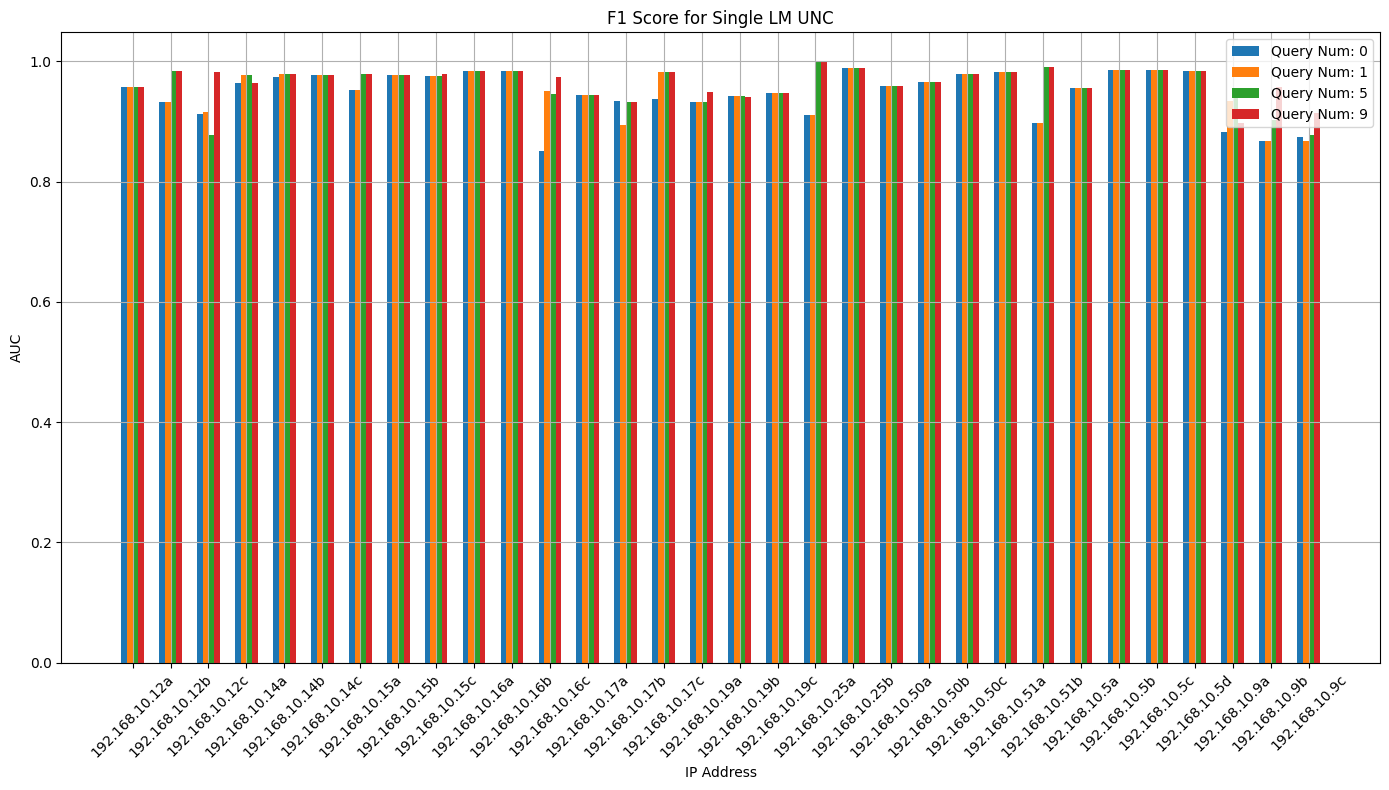

0.9674728934664751

In [ ]:
plot_graph_scenario(metrics_dict, queries_iter = [0,1,5,9], title="F1 Score for Single LM UNC")
metric_values = []

for test_ip in metrics_dict['metric']:
    metric_values.append(metrics_dict['metric'][test_ip][9])

average_metric = np.mean(metric_values)
average_metric

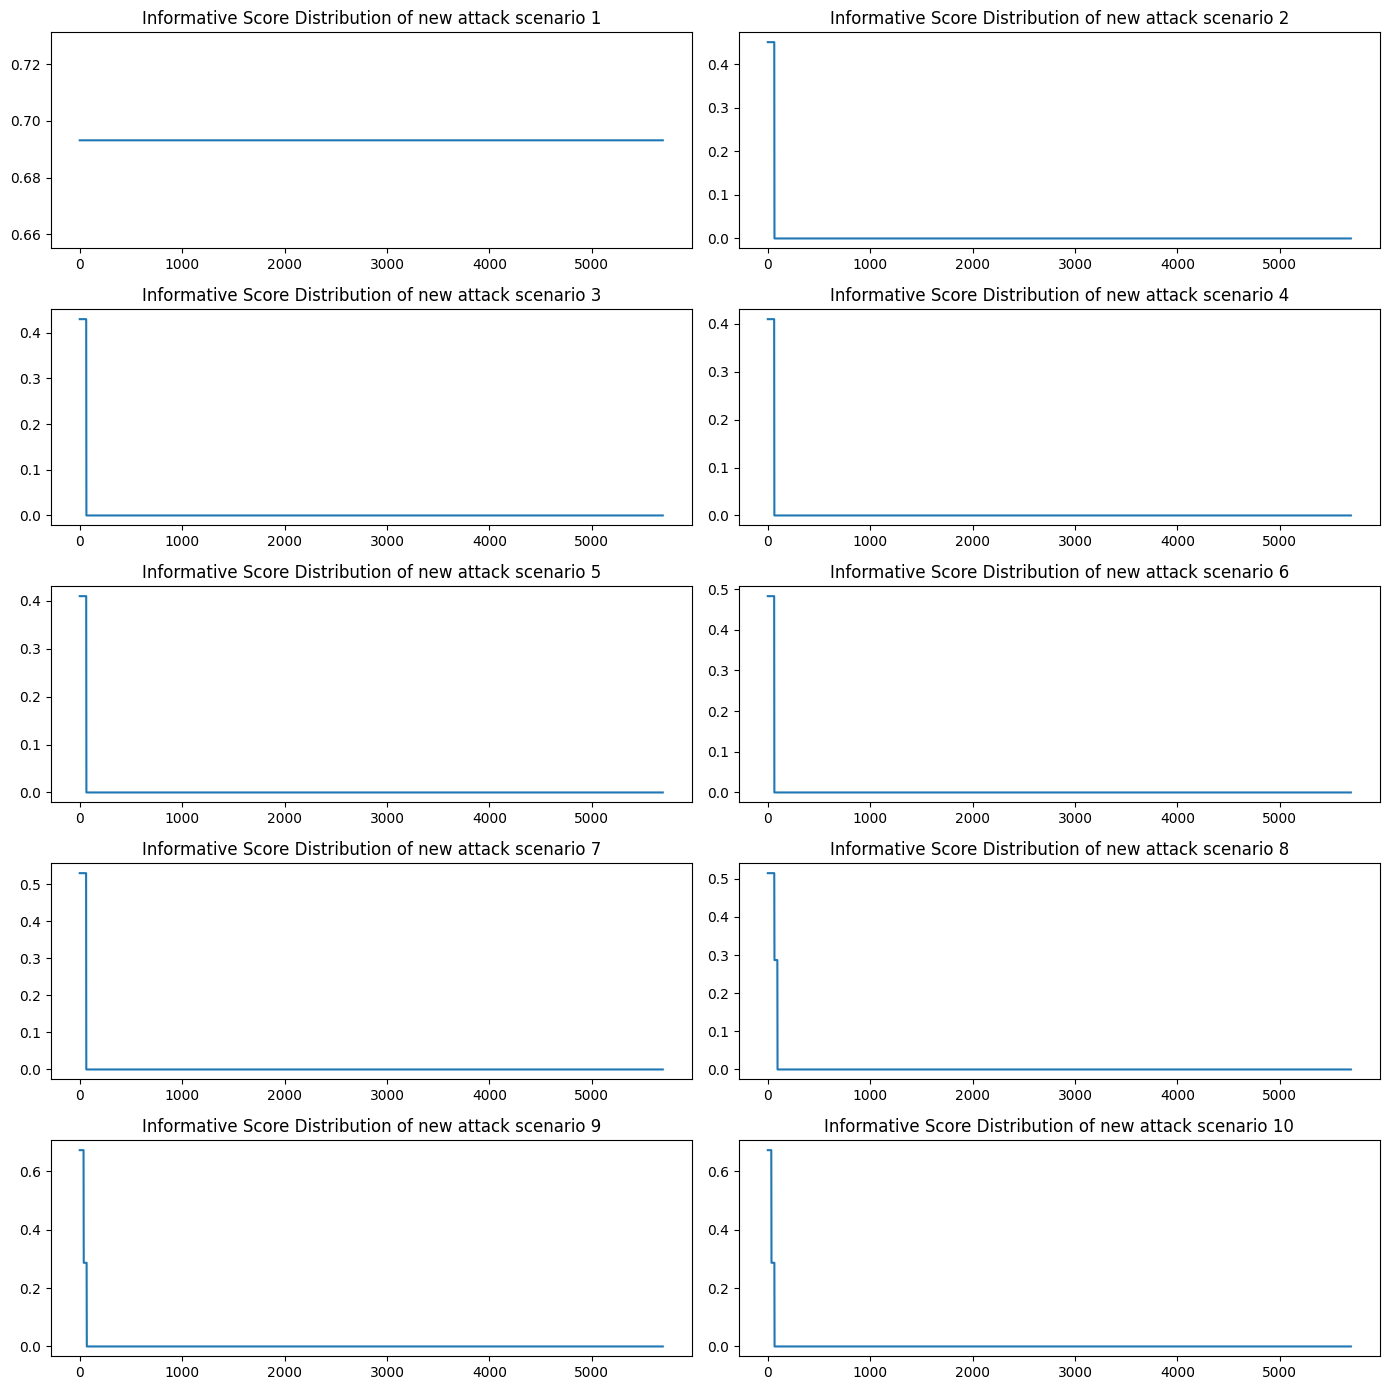

In [ ]:
plot_supporting_scores(metrics_dict['informative_score']["192.168.10.12a"], n_times=10)

In [ ]:
metrics_dict['size']["192.168.10.12a"]

{0: 1006,
 1: 1070,
 2: 1134,
 3: 1197,
 4: 1261,
 5: 1324,
 6: 1387,
 7: 1451,
 8: 1515,
 9: 1577}

New Attack is not applicable to Scenario 2 but we can evaluate how small model affect active learning 

In [ ]:
last_ip = ip
last_ip

'192.168.10.9c'

In [ ]:
# Evaluating One LM


X_known = Xrw_train_scaled[label_ind]
y_known = yrw_train[label_ind]
X_new_scaled_train, X_new_scaled_test, y_new_train, y_new_test = train_test_split(X_new_scaled, Y_new, shuffle=True, test_size=0.2,
                                                                                  stratify=Y_new, random_state=4022)
X = np.concatenate([X_known, X_new_scaled_train])
y = np.concatenate([y_known, y_new_train])
new_label_ind = np.arange(len(X_known))
new_unlab_ind = np.arange(len(X_known), len(X))
alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None, )
alibox_new.split_AL(test_ratio=0.001, initial_label_rate=0.001, split_count=1)
new_strategy = alibox_new.get_query_strategy(strategy_name=strategy_name)

unc_informative_score, unc_query_accuracy, unc_label_ind, model = evaluate_new_atk(X, y, new_strategy, X_new_scaled_test, 
                                                                                   y_new_test, new_label_ind, new_unlab_ind, 
                                                                                   model, metric, threshold = 0.1)
informative_score_list.append(unc_informative_score)
unc_queries_accuracy.append(unc_query_accuracy)
unc_label_size.append(np.shape(unc_label_ind)[0])

([array([45459, 40710, 25497, ..., 43610, 11406, 21284])],
 [array([ 2114, 53074, 38716, 11760,  2455, 51719, 38289, 12675, 32602,
         26331,  4289, 44193, 36143, 27442, 51863, 58750, 19571, 58365,
         24856,  5813, 58806, 21981, 59751, 54423, 30180,  8715,  3317,
          3638, 18480, 53426, 44781, 16738, 57955,  7779, 28744, 44879,
          2200, 44800, 47107, 35333, 35614,  8590, 10988, 27573, 18546,
         28993, 29588, 51555, 34733, 43050, 12387,  1721,  2754, 23943,
         25342, 56976,  3020, 43404, 12749, 46057])],
 [array([45459, 40710, 25497, 30777, 40897, 22375, 37100,  3892, 44935,
         17385, 16692, 42209, 51828, 58856,  5674, 20180, 53253, 37898,
          8492, 36030, 24518, 48421, 42374,  1109, 28558,  9031, 21385,
          5398, 34144, 28759, 45148, 34404, 16841,  9550,   733, 52551,
         34326, 45885, 30225, 53702, 21296, 43162, 53356, 49042, 50228,
         46287,  1100, 10461,  6814, 58486, 53332,  8022, 26709, 36935,
         46644, 57909, 

Added 1000 Shape of Label_ind: (3502,)


### Scenario 3

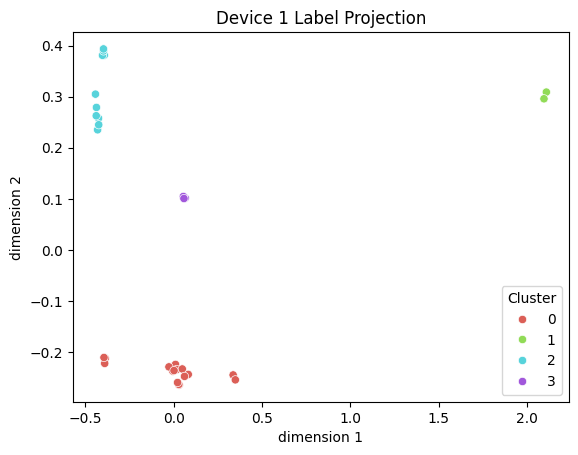

 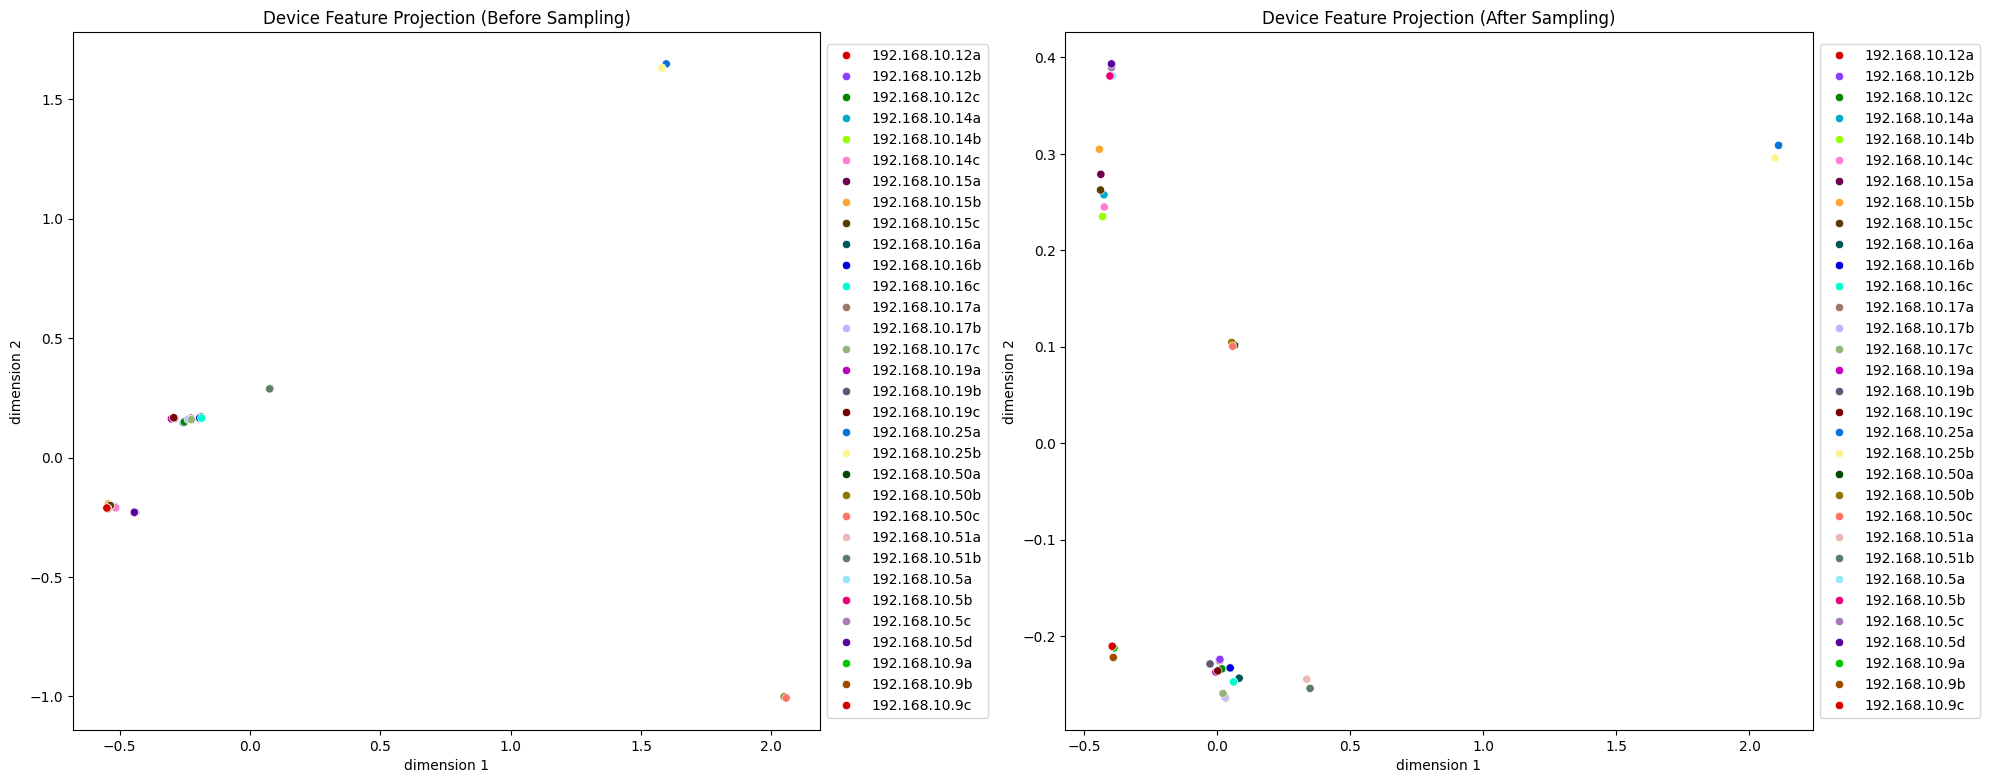

In [14]:
cluster_dict = {
  0: ['192.168.10.12a', '192.168.10.12b', '192.168.10.12c', '192.168.10.16a',
       '192.168.10.16b', '192.168.10.16c', '192.168.10.17a', '192.168.10.17b',
       '192.168.10.17c', '192.168.10.19a', '192.168.10.19b', '192.168.10.19c',
       '192.168.10.51a', '192.168.10.51b', '192.168.10.9a', '192.168.10.9b',
       '192.168.10.9c'],
  1: ['192.168.10.25a', '192.168.10.25b'],
  2: ['192.168.10.14a', '192.168.10.14b', '192.168.10.14c', '192.168.10.15a',
       '192.168.10.15b', '192.168.10.15c', '192.168.10.5a', '192.168.10.5b',
       '192.168.10.5c', '192.168.10.5d'],
  3: ['192.168.10.50a', '192.168.10.50b', '192.168.10.50c']
}

In [ ]:
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
anomaly_rate = 0.05
Xrw_train, Xrw_test, yrw_train, yrw_test, scaler = process_dataset(new_victim_df, anomaly_rate, train_perc=0.8)

Xrw_train.drop(columns=dropping_cols, axis=1, inplace=True)
Xrw_train_scaled = scaler.transform(Xrw_train)
Xrw_test_scaled = Xrw_test.drop(columns=dropping_cols, axis=1, inplace=False)
Xrw_test_scaled = scaler.transform(Xrw_test_scaled)
yrw_train = yrw_train.values
yrw_test = yrw_test.values
round = 10
metrics_dict = {
    'metric': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP},
    'informative_score': {ip : {query : [] for query in range(round)} for ip in new_victim_IP},
    'size': {ip : {query : 0 for query in range(round)} for ip in new_victim_IP}
}      